<a href="https://colab.research.google.com/github/vthavavel/Agriculture/blob/main/AgriTabNet_CSSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

df=pd.read_csv('Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df['label'] = pd.Categorical(df['label'])
label_mapping = dict(enumerate(df['label'].cat.categories))  # Save mapping
df['label'] = df['label'].cat.codes
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


In [ ]:
continuous_features = ["N","P","K","Temperature", "Humidity", "pH", "Rainfall"]  # Modify as needed

# Outlier detection and treatment (Capping at 1st and 99th percentiles)
for col in continuous_features:
    lower_bound = np.percentile(df[col], 1)  # 1st percentile
    upper_bound = np.percentile(df[col], 99)  # 99th percentile
    df[col] = np.clip(df[col], lower_bound, upper_bound)  # Cap outliers

# Apply Min-Max Normalization
scaler = MinMaxScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [ ]:
X = df.drop(['label'],axis=1).values
y = df['label'].values

print(X.shape, y.shape)

(2200, 7) (2200,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_test, X_val, y_test, y_val = train_test_split(X_raw, y_raw, test_size=0.5)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
#print('Val', X_val.shape, y_val.shape)

Train (1760, 7) (1760,)
Test (440, 7) (440,)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 758.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    n_d = trial.suggest_int("n_d", 8, 64)  # Dimension of prediction layer
    n_a = trial.suggest_int("n_a", 8, 64)  # Dimension of attention layer
    n_steps = trial.suggest_int("n_steps", 3, 10)  # Number of decision steps
    gamma = trial.suggest_float("gamma", 1.0, 2.0)  # Relaxation factor
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
    step_size = trial.suggest_int("step_size", 10, 30)  # Step size for LR scheduler
    gamma_scheduler = trial.suggest_float("gamma_scheduler", 0.5, 0.99)  # LR scheduler gamma

    # Initialize TabNet model with suggested hyperparameters
    tabnet_model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        scheduler_params={"step_size": step_size, "gamma": gamma_scheduler},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax'
    )

    # Train the TabNet model
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=10,
        batch_size=128,
        virtual_batch_size=32,
        num_workers=0,
        drop_last=False
    )

    # Evaluate the model on validation data and return validation accuracy
    y_pred = tabnet_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna study to optimize the hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)


[I 2024-11-09 10:00:31,372] A new study created in memory with name: no-name-d11562da-60af-42db-a4f7-0c8fd8f7d09e
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.46421 | train_accuracy: 0.04394 | valid_accuracy: 0.05357 |  0:00:00s
epoch 1  | loss: 2.61445 | train_accuracy: 0.10909 | valid_accuracy: 0.11039 |  0:00:01s
epoch 2  | loss: 2.03529 | train_accuracy: 0.10076 | valid_accuracy: 0.06656 |  0:00:02s
epoch 3  | loss: 1.62809 | train_accuracy: 0.14167 | valid_accuracy: 0.11851 |  0:00:02s
epoch 4  | loss: 1.31501 | train_accuracy: 0.25303 | valid_accuracy: 0.24513 |  0:00:03s
epoch 5  | loss: 1.00683 | train_accuracy: 0.30758 | valid_accuracy: 0.30195 |  0:00:03s
epoch 6  | loss: 0.80673 | train_accuracy: 0.33561 | valid_accuracy: 0.31981 |  0:00:04s
epoch 7  | loss: 0.6759  | train_accuracy: 0.32424 | valid_accuracy: 0.31006 |  0:00:04s
epoch 8  | loss: 0.66638 | train_accuracy: 0.33712 | valid_accuracy: 0.30682 |  0:00:05s
epoch 9  | loss: 0.55207 | train_accuracy: 0.3447  | valid_accuracy: 0.33604 |  0:00:05s
epoch 10 | loss: 0.5639  | train_accuracy: 0.3447  | valid_accuracy: 0.3263  |  0:00:06s
epoch 11 | loss: 0.47

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:01:05,512] Trial 0 finished with value: 0.9886363636363636 and parameters: {'n_d': 14, 'n_a': 17, 'n_steps': 3, 'gamma': 1.5207599246313968, 'lr': 0.009605189754014752, 'step_size': 27, 'gamma_scheduler': 0.6696911824620612}. Best is trial 0 with value: 0.9886363636363636.


epoch 50 | loss: 0.1254  | train_accuracy: 0.98788 | valid_accuracy: 0.98539 |  0:00:26s

Early stopping occurred at epoch 50 with best_epoch = 40 and best_valid_accuracy = 0.98864


<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.85928 | train_accuracy: 0.08712 | valid_accuracy: 0.11201 |  0:00:01s
epoch 1  | loss: 1.56941 | train_accuracy: 0.07424 | valid_accuracy: 0.06169 |  0:00:02s
epoch 2  | loss: 1.02259 | train_accuracy: 0.05303 | valid_accuracy: 0.05844 |  0:00:04s
epoch 3  | loss: 0.91594 | train_accuracy: 0.05909 | valid_accuracy: 0.06981 |  0:00:05s
epoch 4  | loss: 0.91898 | train_accuracy: 0.12879 | valid_accuracy: 0.13636 |  0:00:06s
epoch 5  | loss: 0.66016 | train_accuracy: 0.11742 | valid_accuracy: 0.08117 |  0:00:07s
epoch 6  | loss: 0.54111 | train_accuracy: 0.13106 | valid_accuracy: 0.11688 |  0:00:08s
epoch 7  | loss: 0.46202 | train_accuracy: 0.19545 | valid_accuracy: 0.17532 |  0:00:09s
epoch 8  | loss: 0.5556  | train_accuracy: 0.22576 | valid_accuracy: 0.19968 |  0:00:10s
epoch 9  | loss: 0.33711 | train_accuracy: 0.28409 | valid_accuracy: 0.23539 |  0:00:11s
epoch 10 | loss: 0.3649  | train_accuracy: 0.22879 | valid_accuracy: 0.19156 |  0:00:12s
epoch 11 | loss: 0.30

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:02:05,258] Trial 1 finished with value: 0.9853896103896104 and parameters: {'n_d': 59, 'n_a': 42, 'n_steps': 6, 'gamma': 1.2313688348154899, 'lr': 0.09996742702777944, 'step_size': 22, 'gamma_scheduler': 0.8732248858436567}. Best is trial 0 with value: 0.9886363636363636.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.8275  | train_accuracy: 0.08409 | valid_accuracy: 0.08604 |  0:00:01s
epoch 1  | loss: 1.16932 | train_accuracy: 0.07348 | valid_accuracy: 0.06006 |  0:00:02s
epoch 2  | loss: 0.87962 | train_accuracy: 0.15    | valid_accuracy: 0.16721 |  0:00:03s
epoch 3  | loss: 0.7845  | train_accuracy: 0.09924 | valid_accuracy: 0.11364 |  0:00:03s
epoch 4  | loss: 1.00682 | train_accuracy: 0.13712 | valid_accuracy: 0.12662 |  0:00:04s
epoch 5  | loss: 0.77533 | train_accuracy: 0.09545 | valid_accuracy: 0.10227 |  0:00:05s
epoch 6  | loss: 0.50916 | train_accuracy: 0.17121 | valid_accuracy: 0.16558 |  0:00:06s
epoch 7  | loss: 0.6798  | train_accuracy: 0.21591 | valid_accuracy: 0.21753 |  0:00:06s
epoch 8  | loss: 0.4057  | train_accuracy: 0.24621 | valid_accuracy: 0.25162 |  0:00:07s
epoch 9  | loss: 0.40976 | train_accuracy: 0.2947  | valid_accuracy: 0.31006 |  0:00:08s
epoch 10 | loss: 0.39686 | train_accuracy: 0.40379 | valid_accuracy: 0.42045 |  0:00:09s
epoch 11 | loss: 0.34

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:02:42,573] Trial 2 finished with value: 0.9886363636363636 and parameters: {'n_d': 34, 'n_a': 38, 'n_steps': 5, 'gamma': 1.9899078530730878, 'lr': 0.06227803558603279, 'step_size': 14, 'gamma_scheduler': 0.7332825886921995}. Best is trial 0 with value: 0.9886363636363636.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.03336 | train_accuracy: 0.02652 | valid_accuracy: 0.03084 |  0:00:01s
epoch 1  | loss: 2.07275 | train_accuracy: 0.09318 | valid_accuracy: 0.11201 |  0:00:02s
epoch 2  | loss: 1.71676 | train_accuracy: 0.14773 | valid_accuracy: 0.15584 |  0:00:03s
epoch 3  | loss: 1.48224 | train_accuracy: 0.13788 | valid_accuracy: 0.13799 |  0:00:04s
epoch 4  | loss: 1.21005 | train_accuracy: 0.12121 | valid_accuracy: 0.07955 |  0:00:05s
epoch 5  | loss: 0.8955  | train_accuracy: 0.14091 | valid_accuracy: 0.10552 |  0:00:07s
epoch 6  | loss: 0.78248 | train_accuracy: 0.12803 | valid_accuracy: 0.11688 |  0:00:08s
epoch 7  | loss: 0.73213 | train_accuracy: 0.15758 | valid_accuracy: 0.14935 |  0:00:09s
epoch 8  | loss: 0.79697 | train_accuracy: 0.19924 | valid_accuracy: 0.19481 |  0:00:10s
epoch 9  | loss: 0.95182 | train_accuracy: 0.23864 | valid_accuracy: 0.20942 |  0:00:11s
epoch 10 | loss: 0.85825 | train_accuracy: 0.28636 | valid_accuracy: 0.28734 |  0:00:12s
epoch 11 | loss: 0.60

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:04:08,655] Trial 3 finished with value: 0.9918831168831169 and parameters: {'n_d': 42, 'n_a': 30, 'n_steps': 7, 'gamma': 1.6454291570765196, 'lr': 0.012471711284682467, 'step_size': 18, 'gamma_scheduler': 0.8655491105034174}. Best is trial 3 with value: 0.9918831168831169.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.73906 | train_accuracy: 0.03939 | valid_accuracy: 0.05682 |  0:00:01s
epoch 1  | loss: 2.45728 | train_accuracy: 0.05682 | valid_accuracy: 0.05032 |  0:00:02s
epoch 2  | loss: 1.82299 | train_accuracy: 0.08485 | valid_accuracy: 0.08929 |  0:00:04s
epoch 3  | loss: 1.65216 | train_accuracy: 0.08409 | valid_accuracy: 0.07468 |  0:00:06s
epoch 4  | loss: 1.02822 | train_accuracy: 0.14924 | valid_accuracy: 0.12987 |  0:00:08s
epoch 5  | loss: 0.76524 | train_accuracy: 0.11439 | valid_accuracy: 0.10065 |  0:00:10s
epoch 6  | loss: 0.67565 | train_accuracy: 0.16818 | valid_accuracy: 0.14448 |  0:00:11s
epoch 7  | loss: 0.64601 | train_accuracy: 0.15227 | valid_accuracy: 0.12662 |  0:00:13s
epoch 8  | loss: 0.78848 | train_accuracy: 0.17955 | valid_accuracy: 0.17208 |  0:00:14s
epoch 9  | loss: 0.58259 | train_accuracy: 0.29015 | valid_accuracy: 0.23864 |  0:00:16s
epoch 10 | loss: 0.5263  | train_accuracy: 0.18712 | valid_accuracy: 0.1737  |  0:00:17s
epoch 11 | loss: 0.55

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:05:39,555] Trial 4 finished with value: 0.9853896103896104 and parameters: {'n_d': 29, 'n_a': 57, 'n_steps': 10, 'gamma': 1.8060697228449076, 'lr': 0.03615174086924246, 'step_size': 29, 'gamma_scheduler': 0.6861572989456851}. Best is trial 3 with value: 0.9918831168831169.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.93502 | train_accuracy: 0.07727 | valid_accuracy: 0.09253 |  0:00:00s
epoch 1  | loss: 3.27888 | train_accuracy: 0.07045 | valid_accuracy: 0.07955 |  0:00:01s
epoch 2  | loss: 3.07448 | train_accuracy: 0.03409 | valid_accuracy: 0.03084 |  0:00:02s
epoch 3  | loss: 2.73508 | train_accuracy: 0.04091 | valid_accuracy: 0.03571 |  0:00:02s
epoch 4  | loss: 2.50706 | train_accuracy: 0.05909 | valid_accuracy: 0.04383 |  0:00:03s
epoch 5  | loss: 2.30207 | train_accuracy: 0.07955 | valid_accuracy: 0.05519 |  0:00:04s
epoch 6  | loss: 2.07328 | train_accuracy: 0.08939 | valid_accuracy: 0.0763  |  0:00:05s
epoch 7  | loss: 1.85393 | train_accuracy: 0.08636 | valid_accuracy: 0.07468 |  0:00:06s
epoch 8  | loss: 1.70601 | train_accuracy: 0.09924 | valid_accuracy: 0.07468 |  0:00:06s
epoch 9  | loss: 1.58689 | train_accuracy: 0.11515 | valid_accuracy: 0.11039 |  0:00:07s
epoch 10 | loss: 1.41626 | train_accuracy: 0.15606 | valid_accuracy: 0.13636 |  0:00:07s
epoch 11 | loss: 1.39

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:06:19,937] Trial 5 finished with value: 0.974025974025974 and parameters: {'n_d': 20, 'n_a': 10, 'n_steps': 4, 'gamma': 1.6889444941082652, 'lr': 0.002702497395066538, 'step_size': 20, 'gamma_scheduler': 0.9644518453861931}. Best is trial 3 with value: 0.9918831168831169.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.74302 | train_accuracy: 0.03939 | valid_accuracy: 0.06006 |  0:00:00s
epoch 1  | loss: 6.30291 | train_accuracy: 0.04773 | valid_accuracy: 0.05032 |  0:00:01s
epoch 2  | loss: 5.853   | train_accuracy: 0.05758 | valid_accuracy: 0.06656 |  0:00:02s
epoch 3  | loss: 5.48001 | train_accuracy: 0.06061 | valid_accuracy: 0.07305 |  0:00:03s
epoch 4  | loss: 5.15317 | train_accuracy: 0.09545 | valid_accuracy: 0.09903 |  0:00:04s
epoch 5  | loss: 4.97131 | train_accuracy: 0.09621 | valid_accuracy: 0.11201 |  0:00:05s
epoch 6  | loss: 4.73006 | train_accuracy: 0.07727 | valid_accuracy: 0.0974  |  0:00:06s
epoch 7  | loss: 4.57818 | train_accuracy: 0.06364 | valid_accuracy: 0.07792 |  0:00:07s
epoch 8  | loss: 4.43376 | train_accuracy: 0.05303 | valid_accuracy: 0.05844 |  0:00:08s
epoch 9  | loss: 4.21291 | train_accuracy: 0.04167 | valid_accuracy: 0.04383 |  0:00:09s
epoch 10 | loss: 4.00576 | train_accuracy: 0.03409 | valid_accuracy: 0.0276  |  0:00:10s
epoch 11 | loss: 3.77

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:06:34,341] Trial 6 finished with value: 0.11201298701298701 and parameters: {'n_d': 16, 'n_a': 20, 'n_steps': 6, 'gamma': 1.9309720476110894, 'lr': 0.0009458647719061081, 'step_size': 25, 'gamma_scheduler': 0.9620872778896681}. Best is trial 3 with value: 0.9918831168831169.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.75209 | train_accuracy: 0.11364 | valid_accuracy: 0.09578 |  0:00:01s
epoch 1  | loss: 1.33181 | train_accuracy: 0.06894 | valid_accuracy: 0.0763  |  0:00:02s
epoch 2  | loss: 0.98236 | train_accuracy: 0.09091 | valid_accuracy: 0.09091 |  0:00:03s
epoch 3  | loss: 0.88466 | train_accuracy: 0.08712 | valid_accuracy: 0.07955 |  0:00:04s
epoch 4  | loss: 0.65236 | train_accuracy: 0.09015 | valid_accuracy: 0.0974  |  0:00:06s
epoch 5  | loss: 0.6504  | train_accuracy: 0.21364 | valid_accuracy: 0.17045 |  0:00:07s
epoch 6  | loss: 0.64782 | train_accuracy: 0.17576 | valid_accuracy: 0.16234 |  0:00:08s
epoch 7  | loss: 0.56542 | train_accuracy: 0.14167 | valid_accuracy: 0.14935 |  0:00:09s
epoch 8  | loss: 0.57816 | train_accuracy: 0.22955 | valid_accuracy: 0.21104 |  0:00:10s
epoch 9  | loss: 0.69003 | train_accuracy: 0.24848 | valid_accuracy: 0.22078 |  0:00:12s
epoch 10 | loss: 0.47922 | train_accuracy: 0.38182 | valid_accuracy: 0.35714 |  0:00:13s
epoch 11 | loss: 0.49

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:07:35,292] Trial 7 finished with value: 0.9935064935064936 and parameters: {'n_d': 33, 'n_a': 47, 'n_steps': 7, 'gamma': 1.8824059015878842, 'lr': 0.03239775818649704, 'step_size': 19, 'gamma_scheduler': 0.5642478813533393}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.35765 | train_accuracy: 0.02803 | valid_accuracy: 0.01786 |  0:00:01s
epoch 1  | loss: 2.22105 | train_accuracy: 0.08485 | valid_accuracy: 0.08929 |  0:00:03s
epoch 2  | loss: 1.48425 | train_accuracy: 0.12955 | valid_accuracy: 0.10714 |  0:00:05s
epoch 3  | loss: 1.09917 | train_accuracy: 0.14015 | valid_accuracy: 0.13312 |  0:00:06s
epoch 4  | loss: 0.82142 | train_accuracy: 0.22348 | valid_accuracy: 0.22727 |  0:00:08s
epoch 5  | loss: 0.71573 | train_accuracy: 0.24318 | valid_accuracy: 0.21916 |  0:00:09s
epoch 6  | loss: 0.73891 | train_accuracy: 0.21439 | valid_accuracy: 0.18344 |  0:00:10s
epoch 7  | loss: 0.73403 | train_accuracy: 0.25    | valid_accuracy: 0.25812 |  0:00:12s
epoch 8  | loss: 0.6713  | train_accuracy: 0.23182 | valid_accuracy: 0.20617 |  0:00:13s
epoch 9  | loss: 0.66511 | train_accuracy: 0.23939 | valid_accuracy: 0.21753 |  0:00:14s
epoch 10 | loss: 0.67344 | train_accuracy: 0.26818 | valid_accuracy: 0.2711  |  0:00:16s
epoch 11 | loss: 0.55

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:09:02,594] Trial 8 finished with value: 0.9837662337662337 and parameters: {'n_d': 64, 'n_a': 52, 'n_steps': 8, 'gamma': 1.361921704066266, 'lr': 0.004013787691523576, 'step_size': 18, 'gamma_scheduler': 0.7664642566627575}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.78606 | train_accuracy: 0.06515 | valid_accuracy: 0.05519 |  0:00:01s
epoch 1  | loss: 4.02641 | train_accuracy: 0.11515 | valid_accuracy: 0.11364 |  0:00:02s
epoch 2  | loss: 2.97215 | train_accuracy: 0.04318 | valid_accuracy: 0.03409 |  0:00:03s
epoch 3  | loss: 2.39678 | train_accuracy: 0.0697  | valid_accuracy: 0.06818 |  0:00:04s
epoch 4  | loss: 2.07969 | train_accuracy: 0.07955 | valid_accuracy: 0.06981 |  0:00:05s
epoch 5  | loss: 1.82498 | train_accuracy: 0.07121 | valid_accuracy: 0.06169 |  0:00:06s
epoch 6  | loss: 1.62862 | train_accuracy: 0.14318 | valid_accuracy: 0.13149 |  0:00:07s
epoch 7  | loss: 1.47718 | train_accuracy: 0.13561 | valid_accuracy: 0.13312 |  0:00:08s
epoch 8  | loss: 1.35547 | train_accuracy: 0.19545 | valid_accuracy: 0.19156 |  0:00:09s
epoch 9  | loss: 1.26378 | train_accuracy: 0.2553  | valid_accuracy: 0.25    |  0:00:10s
epoch 10 | loss: 1.11575 | train_accuracy: 0.35    | valid_accuracy: 0.34416 |  0:00:11s
epoch 11 | loss: 1.05

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:09:46,630] Trial 9 finished with value: 0.939935064935065 and parameters: {'n_d': 41, 'n_a': 8, 'n_steps': 7, 'gamma': 1.9191872264828502, 'lr': 0.0036561848382893956, 'step_size': 15, 'gamma_scheduler': 0.8152876161566105}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.58448| train_accuracy: 0.05152 | valid_accuracy: 0.04383 |  0:00:02s
epoch 1  | loss: 10.28802| train_accuracy: 0.05606 | valid_accuracy: 0.04708 |  0:00:03s
epoch 2  | loss: 9.89078 | train_accuracy: 0.0553  | valid_accuracy: 0.04058 |  0:00:05s
epoch 3  | loss: 9.56681 | train_accuracy: 0.04621 | valid_accuracy: 0.04545 |  0:00:06s
epoch 4  | loss: 9.33086 | train_accuracy: 0.0553  | valid_accuracy: 0.04545 |  0:00:08s
epoch 5  | loss: 8.99725 | train_accuracy: 0.07045 | valid_accuracy: 0.06656 |  0:00:09s
epoch 6  | loss: 8.56963 | train_accuracy: 0.07045 | valid_accuracy: 0.06981 |  0:00:11s
epoch 7  | loss: 8.41937 | train_accuracy: 0.07727 | valid_accuracy: 0.0763  |  0:00:13s
epoch 8  | loss: 7.93668 | train_accuracy: 0.08939 | valid_accuracy: 0.0974  |  0:00:15s
epoch 9  | loss: 7.74233 | train_accuracy: 0.07879 | valid_accuracy: 0.11201 |  0:00:17s
epoch 10 | loss: 7.58692 | train_accuracy: 0.08106 | valid_accuracy: 0.09578 |  0:00:19s
epoch 11 | loss: 7.38

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:10:21,624] Trial 10 finished with value: 0.11201298701298701 and parameters: {'n_d': 53, 'n_a': 64, 'n_steps': 9, 'gamma': 1.0989495230026973, 'lr': 0.0001081698164186764, 'step_size': 10, 'gamma_scheduler': 0.5126891336134958}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.26745 | train_accuracy: 0.02045 | valid_accuracy: 0.03084 |  0:00:01s
epoch 1  | loss: 1.82808 | train_accuracy: 0.09697 | valid_accuracy: 0.08442 |  0:00:02s
epoch 2  | loss: 1.62048 | train_accuracy: 0.07652 | valid_accuracy: 0.07143 |  0:00:03s
epoch 3  | loss: 1.15532 | train_accuracy: 0.0947  | valid_accuracy: 0.10714 |  0:00:04s
epoch 4  | loss: 1.05615 | train_accuracy: 0.08485 | valid_accuracy: 0.08117 |  0:00:05s
epoch 5  | loss: 0.82543 | train_accuracy: 0.09015 | valid_accuracy: 0.07792 |  0:00:07s
epoch 6  | loss: 0.72496 | train_accuracy: 0.15455 | valid_accuracy: 0.16234 |  0:00:09s
epoch 7  | loss: 0.74387 | train_accuracy: 0.14091 | valid_accuracy: 0.14286 |  0:00:10s
epoch 8  | loss: 0.64425 | train_accuracy: 0.13788 | valid_accuracy: 0.12175 |  0:00:11s
epoch 9  | loss: 0.78315 | train_accuracy: 0.17803 | valid_accuracy: 0.18994 |  0:00:12s
epoch 10 | loss: 0.77284 | train_accuracy: 0.19621 | valid_accuracy: 0.2013  |  0:00:14s
epoch 11 | loss: 0.59

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:11:20,688] Trial 11 finished with value: 0.987012987012987 and parameters: {'n_d': 45, 'n_a': 27, 'n_steps': 8, 'gamma': 1.6214743962027394, 'lr': 0.01654281021167847, 'step_size': 17, 'gamma_scheduler': 0.5001386018270703}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.58544 | train_accuracy: 0.09167 | valid_accuracy: 0.10065 |  0:00:01s
epoch 1  | loss: 2.30644 | train_accuracy: 0.12348 | valid_accuracy: 0.12175 |  0:00:02s
epoch 2  | loss: 1.53561 | train_accuracy: 0.12879 | valid_accuracy: 0.11688 |  0:00:03s
epoch 3  | loss: 1.25452 | train_accuracy: 0.13258 | valid_accuracy: 0.11039 |  0:00:04s
epoch 4  | loss: 1.10435 | train_accuracy: 0.04015 | valid_accuracy: 0.04221 |  0:00:05s
epoch 5  | loss: 0.85039 | train_accuracy: 0.11439 | valid_accuracy: 0.11364 |  0:00:07s
epoch 6  | loss: 0.74616 | train_accuracy: 0.08333 | valid_accuracy: 0.0974  |  0:00:08s
epoch 7  | loss: 0.61941 | train_accuracy: 0.17045 | valid_accuracy: 0.18182 |  0:00:09s
epoch 8  | loss: 0.61006 | train_accuracy: 0.14621 | valid_accuracy: 0.16396 |  0:00:10s
epoch 9  | loss: 0.44173 | train_accuracy: 0.14091 | valid_accuracy: 0.14286 |  0:00:11s
epoch 10 | loss: 0.4906  | train_accuracy: 0.20985 | valid_accuracy: 0.20617 |  0:00:12s
epoch 11 | loss: 0.47

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:12:14,982] Trial 12 finished with value: 0.987012987012987 and parameters: {'n_d': 28, 'n_a': 46, 'n_steps': 7, 'gamma': 1.7613453758347648, 'lr': 0.018544145399505264, 'step_size': 23, 'gamma_scheduler': 0.6141192704345371}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.5951  | train_accuracy: 0.03485 | valid_accuracy: 0.0487  |  0:00:01s
epoch 1  | loss: 2.29813 | train_accuracy: 0.0947  | valid_accuracy: 0.07955 |  0:00:02s
epoch 2  | loss: 1.39027 | train_accuracy: 0.14924 | valid_accuracy: 0.12662 |  0:00:03s
epoch 3  | loss: 1.26535 | train_accuracy: 0.11212 | valid_accuracy: 0.09578 |  0:00:04s
epoch 4  | loss: 0.99202 | train_accuracy: 0.17424 | valid_accuracy: 0.1737  |  0:00:06s
epoch 5  | loss: 0.83    | train_accuracy: 0.18864 | valid_accuracy: 0.17208 |  0:00:07s
epoch 6  | loss: 0.82647 | train_accuracy: 0.16742 | valid_accuracy: 0.1461  |  0:00:09s
epoch 7  | loss: 0.74909 | train_accuracy: 0.16515 | valid_accuracy: 0.13961 |  0:00:10s
epoch 8  | loss: 0.72013 | train_accuracy: 0.17652 | valid_accuracy: 0.16234 |  0:00:12s
epoch 9  | loss: 0.67461 | train_accuracy: 0.18485 | valid_accuracy: 0.14123 |  0:00:13s
epoch 10 | loss: 0.5465  | train_accuracy: 0.29091 | valid_accuracy: 0.25487 |  0:00:14s
epoch 11 | loss: 0.55

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:13:18,685] Trial 13 finished with value: 0.9853896103896104 and parameters: {'n_d': 48, 'n_a': 33, 'n_steps': 8, 'gamma': 1.5471915675580865, 'lr': 0.009265284929549191, 'step_size': 11, 'gamma_scheduler': 0.8722188715892211}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.74346 | train_accuracy: 0.11818 | valid_accuracy: 0.13149 |  0:00:00s
epoch 1  | loss: 1.06081 | train_accuracy: 0.08333 | valid_accuracy: 0.08766 |  0:00:01s
epoch 2  | loss: 0.73127 | train_accuracy: 0.18485 | valid_accuracy: 0.19318 |  0:00:02s
epoch 3  | loss: 0.76411 | train_accuracy: 0.12803 | valid_accuracy: 0.14935 |  0:00:04s
epoch 4  | loss: 0.75464 | train_accuracy: 0.14394 | valid_accuracy: 0.13312 |  0:00:05s
epoch 5  | loss: 0.4991  | train_accuracy: 0.18939 | valid_accuracy: 0.15747 |  0:00:06s
epoch 6  | loss: 0.4432  | train_accuracy: 0.24091 | valid_accuracy: 0.20942 |  0:00:06s
epoch 7  | loss: 0.50389 | train_accuracy: 0.17803 | valid_accuracy: 0.19318 |  0:00:07s
epoch 8  | loss: 0.39115 | train_accuracy: 0.22348 | valid_accuracy: 0.22565 |  0:00:08s
epoch 9  | loss: 0.36794 | train_accuracy: 0.22879 | valid_accuracy: 0.24026 |  0:00:09s
epoch 10 | loss: 0.3229  | train_accuracy: 0.33182 | valid_accuracy: 0.36688 |  0:00:09s
epoch 11 | loss: 0.31

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:14:12,429] Trial 14 finished with value: 0.9935064935064936 and parameters: {'n_d': 37, 'n_a': 29, 'n_steps': 5, 'gamma': 1.403414467091912, 'lr': 0.035881315573299585, 'step_size': 20, 'gamma_scheduler': 0.6028925332450583}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.65127 | train_accuracy: 0.04773 | valid_accuracy: 0.04708 |  0:00:00s
epoch 1  | loss: 1.2221  | train_accuracy: 0.06136 | valid_accuracy: 0.06331 |  0:00:01s
epoch 2  | loss: 0.82656 | train_accuracy: 0.14242 | valid_accuracy: 0.14448 |  0:00:02s
epoch 3  | loss: 0.63546 | train_accuracy: 0.15    | valid_accuracy: 0.13961 |  0:00:03s
epoch 4  | loss: 0.52749 | train_accuracy: 0.19394 | valid_accuracy: 0.17695 |  0:00:04s
epoch 5  | loss: 0.4804  | train_accuracy: 0.1447  | valid_accuracy: 0.14935 |  0:00:04s
epoch 6  | loss: 0.38284 | train_accuracy: 0.20833 | valid_accuracy: 0.20942 |  0:00:06s
epoch 7  | loss: 0.38438 | train_accuracy: 0.21288 | valid_accuracy: 0.20455 |  0:00:07s
epoch 8  | loss: 0.31389 | train_accuracy: 0.20379 | valid_accuracy: 0.18506 |  0:00:08s
epoch 9  | loss: 0.37608 | train_accuracy: 0.2197  | valid_accuracy: 0.24026 |  0:00:09s
epoch 10 | loss: 0.3513  | train_accuracy: 0.26515 | valid_accuracy: 0.24675 |  0:00:10s
epoch 11 | loss: 0.32

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:15:14,782] Trial 15 finished with value: 0.9935064935064936 and parameters: {'n_d': 26, 'n_a': 48, 'n_steps': 5, 'gamma': 1.3610743478623604, 'lr': 0.041459431487026355, 'step_size': 21, 'gamma_scheduler': 0.5717424318707497}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.22213 | train_accuracy: 0.0303  | valid_accuracy: 0.0276  |  0:00:00s
epoch 1  | loss: 4.93849 | train_accuracy: 0.07348 | valid_accuracy: 0.0487  |  0:00:01s
epoch 2  | loss: 4.67037 | train_accuracy: 0.05076 | valid_accuracy: 0.02597 |  0:00:03s
epoch 3  | loss: 4.42349 | train_accuracy: 0.05    | valid_accuracy: 0.03571 |  0:00:04s
epoch 4  | loss: 4.27216 | train_accuracy: 0.03939 | valid_accuracy: 0.03084 |  0:00:04s
epoch 5  | loss: 4.05727 | train_accuracy: 0.02955 | valid_accuracy: 0.0276  |  0:00:05s
epoch 6  | loss: 3.91751 | train_accuracy: 0.03182 | valid_accuracy: 0.02597 |  0:00:06s
epoch 7  | loss: 3.80153 | train_accuracy: 0.02348 | valid_accuracy: 0.03409 |  0:00:06s
epoch 8  | loss: 3.70887 | train_accuracy: 0.03485 | valid_accuracy: 0.02922 |  0:00:07s
epoch 9  | loss: 3.59292 | train_accuracy: 0.03788 | valid_accuracy: 0.04058 |  0:00:08s
epoch 10 | loss: 3.53159 | train_accuracy: 0.0553  | valid_accuracy: 0.06656 |  0:00:08s
epoch 11 | loss: 3.43

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:16:32,293] Trial 16 finished with value: 0.577922077922078 and parameters: {'n_d': 8, 'n_a': 24, 'n_steps': 5, 'gamma': 1.3289460199153376, 'lr': 0.0007422213574692462, 'step_size': 24, 'gamma_scheduler': 0.5826488943029613}. Best is trial 7 with value: 0.9935064935064936.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.27845 | train_accuracy: 0.07045 | valid_accuracy: 0.04545 |  0:00:00s
epoch 1  | loss: 0.89903 | train_accuracy: 0.125   | valid_accuracy: 0.10227 |  0:00:01s
epoch 2  | loss: 0.71135 | train_accuracy: 0.05682 | valid_accuracy: 0.05519 |  0:00:01s
epoch 3  | loss: 0.4856  | train_accuracy: 0.08788 | valid_accuracy: 0.10065 |  0:00:02s
epoch 4  | loss: 0.41061 | train_accuracy: 0.19621 | valid_accuracy: 0.19481 |  0:00:02s
epoch 5  | loss: 0.37879 | train_accuracy: 0.10833 | valid_accuracy: 0.11851 |  0:00:03s
epoch 6  | loss: 0.36403 | train_accuracy: 0.22803 | valid_accuracy: 0.21753 |  0:00:03s
epoch 7  | loss: 0.32663 | train_accuracy: 0.17121 | valid_accuracy: 0.16396 |  0:00:04s
epoch 8  | loss: 0.28466 | train_accuracy: 0.37424 | valid_accuracy: 0.35877 |  0:00:04s
epoch 9  | loss: 0.2739  | train_accuracy: 0.2803  | valid_accuracy: 0.29058 |  0:00:05s
epoch 10 | loss: 0.20706 | train_accuracy: 0.29394 | valid_accuracy: 0.31818 |  0:00:06s
epoch 11 | loss: 0.20

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:17:04,437] Trial 17 finished with value: 0.9967532467532467 and parameters: {'n_d': 36, 'n_a': 37, 'n_steps': 3, 'gamma': 1.0997356826879314, 'lr': 0.045156626136169775, 'step_size': 14, 'gamma_scheduler': 0.6343143083500575}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.23274 | train_accuracy: 0.12727 | valid_accuracy: 0.11039 |  0:00:00s
epoch 1  | loss: 0.9679  | train_accuracy: 0.1303  | valid_accuracy: 0.10227 |  0:00:01s
epoch 2  | loss: 0.77084 | train_accuracy: 0.08333 | valid_accuracy: 0.07305 |  0:00:01s
epoch 3  | loss: 0.61105 | train_accuracy: 0.10682 | valid_accuracy: 0.0974  |  0:00:02s
epoch 4  | loss: 0.4897  | train_accuracy: 0.16439 | valid_accuracy: 0.16883 |  0:00:02s
epoch 5  | loss: 0.42204 | train_accuracy: 0.11894 | valid_accuracy: 0.10065 |  0:00:03s
epoch 6  | loss: 0.46758 | train_accuracy: 0.16136 | valid_accuracy: 0.16883 |  0:00:03s
epoch 7  | loss: 0.52753 | train_accuracy: 0.15379 | valid_accuracy: 0.14773 |  0:00:04s
epoch 8  | loss: 0.47082 | train_accuracy: 0.23485 | valid_accuracy: 0.21429 |  0:00:05s
epoch 9  | loss: 0.39833 | train_accuracy: 0.23258 | valid_accuracy: 0.25325 |  0:00:05s
epoch 10 | loss: 0.34226 | train_accuracy: 0.24848 | valid_accuracy: 0.25812 |  0:00:06s
epoch 11 | loss: 0.45

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:17:39,733] Trial 18 finished with value: 0.9902597402597403 and parameters: {'n_d': 34, 'n_a': 37, 'n_steps': 3, 'gamma': 1.163407824445943, 'lr': 0.08040370755539666, 'step_size': 14, 'gamma_scheduler': 0.6498140342626979}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.69856 | train_accuracy: 0.07348 | valid_accuracy: 0.05357 |  0:00:01s
epoch 1  | loss: 3.07528 | train_accuracy: 0.06591 | valid_accuracy: 0.05032 |  0:00:02s
epoch 2  | loss: 2.07073 | train_accuracy: 0.11894 | valid_accuracy: 0.07792 |  0:00:03s
epoch 3  | loss: 1.59198 | train_accuracy: 0.11667 | valid_accuracy: 0.11364 |  0:00:03s
epoch 4  | loss: 1.26411 | train_accuracy: 0.1197  | valid_accuracy: 0.09253 |  0:00:04s
epoch 5  | loss: 1.02837 | train_accuracy: 0.12576 | valid_accuracy: 0.12175 |  0:00:05s
epoch 6  | loss: 0.80959 | train_accuracy: 0.1803  | valid_accuracy: 0.13961 |  0:00:06s
epoch 7  | loss: 0.6999  | train_accuracy: 0.19167 | valid_accuracy: 0.19156 |  0:00:06s
epoch 8  | loss: 0.65368 | train_accuracy: 0.18485 | valid_accuracy: 0.18506 |  0:00:07s
epoch 9  | loss: 0.55554 | train_accuracy: 0.25152 | valid_accuracy: 0.24513 |  0:00:08s
epoch 10 | loss: 0.49141 | train_accuracy: 0.27045 | valid_accuracy: 0.24351 |  0:00:09s
epoch 11 | loss: 0.42

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:18:33,358] Trial 19 finished with value: 0.9902597402597403 and parameters: {'n_d': 51, 'n_a': 56, 'n_steps': 4, 'gamma': 1.0126239646105042, 'lr': 0.0014579423899340029, 'step_size': 12, 'gamma_scheduler': 0.5439866860052218}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.49028 | train_accuracy: 0.0447  | valid_accuracy: 0.05682 |  0:00:01s
epoch 1  | loss: 9.21629 | train_accuracy: 0.02348 | valid_accuracy: 0.02435 |  0:00:03s
epoch 2  | loss: 8.76632 | train_accuracy: 0.03485 | valid_accuracy: 0.04708 |  0:00:04s
epoch 3  | loss: 8.37847 | train_accuracy: 0.03864 | valid_accuracy: 0.03896 |  0:00:06s
epoch 4  | loss: 7.8662  | train_accuracy: 0.04773 | valid_accuracy: 0.05682 |  0:00:08s
epoch 5  | loss: 7.60265 | train_accuracy: 0.06439 | valid_accuracy: 0.07468 |  0:00:09s
epoch 6  | loss: 7.30256 | train_accuracy: 0.08485 | valid_accuracy: 0.0763  |  0:00:10s
epoch 7  | loss: 6.96401 | train_accuracy: 0.07652 | valid_accuracy: 0.09091 |  0:00:12s
epoch 8  | loss: 6.5969  | train_accuracy: 0.07273 | valid_accuracy: 0.07305 |  0:00:13s
epoch 9  | loss: 6.11465 | train_accuracy: 0.07121 | valid_accuracy: 0.07305 |  0:00:15s
epoch 10 | loss: 5.86626 | train_accuracy: 0.07803 | valid_accuracy: 0.08117 |  0:00:16s
epoch 11 | loss: 5.62

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:21:07,663] Trial 20 finished with value: 0.7678571428571429 and parameters: {'n_d': 23, 'n_a': 42, 'n_steps': 10, 'gamma': 1.0073198898889693, 'lr': 0.000270240739921602, 'step_size': 15, 'gamma_scheduler': 0.7227574320025729}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.82429 | train_accuracy: 0.12727 | valid_accuracy: 0.11364 |  0:00:00s
epoch 1  | loss: 1.22502 | train_accuracy: 0.08182 | valid_accuracy: 0.08604 |  0:00:01s
epoch 2  | loss: 0.90727 | train_accuracy: 0.12197 | valid_accuracy: 0.09903 |  0:00:02s
epoch 3  | loss: 0.80828 | train_accuracy: 0.04773 | valid_accuracy: 0.0487  |  0:00:02s
epoch 4  | loss: 0.58284 | train_accuracy: 0.09091 | valid_accuracy: 0.08929 |  0:00:03s
epoch 5  | loss: 0.51216 | train_accuracy: 0.05758 | valid_accuracy: 0.06006 |  0:00:03s
epoch 6  | loss: 0.42895 | train_accuracy: 0.09015 | valid_accuracy: 0.09091 |  0:00:04s
epoch 7  | loss: 0.41197 | train_accuracy: 0.07576 | valid_accuracy: 0.08929 |  0:00:05s
epoch 8  | loss: 0.39598 | train_accuracy: 0.175   | valid_accuracy: 0.16721 |  0:00:06s
epoch 9  | loss: 0.33467 | train_accuracy: 0.15682 | valid_accuracy: 0.16558 |  0:00:07s
epoch 10 | loss: 0.26589 | train_accuracy: 0.17424 | valid_accuracy: 0.18344 |  0:00:08s
epoch 11 | loss: 0.27

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:21:48,702] Trial 21 finished with value: 0.9935064935064936 and parameters: {'n_d': 38, 'n_a': 34, 'n_steps': 4, 'gamma': 1.430710488496573, 'lr': 0.027079455415910628, 'step_size': 17, 'gamma_scheduler': 0.6253060749565568}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.31484 | train_accuracy: 0.03712 | valid_accuracy: 0.04058 |  0:00:00s
epoch 1  | loss: 0.90023 | train_accuracy: 0.12197 | valid_accuracy: 0.13149 |  0:00:01s
epoch 2  | loss: 0.63977 | train_accuracy: 0.1     | valid_accuracy: 0.0974  |  0:00:01s
epoch 3  | loss: 0.62512 | train_accuracy: 0.08864 | valid_accuracy: 0.10552 |  0:00:02s
epoch 4  | loss: 0.43753 | train_accuracy: 0.125   | valid_accuracy: 0.13799 |  0:00:02s
epoch 5  | loss: 0.38341 | train_accuracy: 0.14545 | valid_accuracy: 0.16071 |  0:00:03s
epoch 6  | loss: 0.37134 | train_accuracy: 0.13939 | valid_accuracy: 0.17532 |  0:00:03s
epoch 7  | loss: 0.32874 | train_accuracy: 0.16061 | valid_accuracy: 0.18019 |  0:00:04s
epoch 8  | loss: 0.31614 | train_accuracy: 0.17121 | valid_accuracy: 0.18506 |  0:00:04s
epoch 9  | loss: 0.36007 | train_accuracy: 0.30379 | valid_accuracy: 0.33604 |  0:00:05s
epoch 10 | loss: 0.30847 | train_accuracy: 0.27727 | valid_accuracy: 0.29545 |  0:00:06s
epoch 11 | loss: 0.32

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:22:19,332] Trial 22 finished with value: 0.9886363636363636 and parameters: {'n_d': 31, 'n_a': 42, 'n_steps': 3, 'gamma': 1.2450589416260205, 'lr': 0.04295798193477196, 'step_size': 19, 'gamma_scheduler': 0.5771550552743249}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.82778 | train_accuracy: 0.07045 | valid_accuracy: 0.06494 |  0:00:00s
epoch 1  | loss: 2.43384 | train_accuracy: 0.08409 | valid_accuracy: 0.06656 |  0:00:01s
epoch 2  | loss: 1.66571 | train_accuracy: 0.04773 | valid_accuracy: 0.05357 |  0:00:02s
epoch 3  | loss: 1.23282 | train_accuracy: 0.06742 | valid_accuracy: 0.06169 |  0:00:03s
epoch 4  | loss: 1.04584 | train_accuracy: 0.07424 | valid_accuracy: 0.06331 |  0:00:04s
epoch 5  | loss: 0.87862 | train_accuracy: 0.06364 | valid_accuracy: 0.05032 |  0:00:05s
epoch 6  | loss: 0.81593 | train_accuracy: 0.11061 | valid_accuracy: 0.09578 |  0:00:06s
epoch 7  | loss: 0.71763 | train_accuracy: 0.17121 | valid_accuracy: 0.15097 |  0:00:07s
epoch 8  | loss: 0.64902 | train_accuracy: 0.10985 | valid_accuracy: 0.11851 |  0:00:09s
epoch 9  | loss: 0.6177  | train_accuracy: 0.15606 | valid_accuracy: 0.13636 |  0:00:10s
epoch 10 | loss: 0.54413 | train_accuracy: 0.25227 | valid_accuracy: 0.2224  |  0:00:11s
epoch 11 | loss: 0.51

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:23:21,719] Trial 23 finished with value: 0.9788961038961039 and parameters: {'n_d': 38, 'n_a': 29, 'n_steps': 6, 'gamma': 1.4529548222559043, 'lr': 0.0056372915095815705, 'step_size': 20, 'gamma_scheduler': 0.617258912666481}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.18792 | train_accuracy: 0.11667 | valid_accuracy: 0.11039 |  0:00:01s
epoch 1  | loss: 1.23626 | train_accuracy: 0.06364 | valid_accuracy: 0.06331 |  0:00:02s
epoch 2  | loss: 0.82218 | train_accuracy: 0.12879 | valid_accuracy: 0.11201 |  0:00:03s
epoch 3  | loss: 0.67246 | train_accuracy: 0.07273 | valid_accuracy: 0.07143 |  0:00:04s
epoch 4  | loss: 0.53124 | train_accuracy: 0.06288 | valid_accuracy: 0.05682 |  0:00:05s
epoch 5  | loss: 0.36159 | train_accuracy: 0.14091 | valid_accuracy: 0.13474 |  0:00:05s
epoch 6  | loss: 0.33455 | train_accuracy: 0.175   | valid_accuracy: 0.16234 |  0:00:06s
epoch 7  | loss: 0.26642 | train_accuracy: 0.19545 | valid_accuracy: 0.18506 |  0:00:07s
epoch 8  | loss: 0.28516 | train_accuracy: 0.24848 | valid_accuracy: 0.22078 |  0:00:07s
epoch 9  | loss: 0.28358 | train_accuracy: 0.29773 | valid_accuracy: 0.2987  |  0:00:08s
epoch 10 | loss: 0.23841 | train_accuracy: 0.31288 | valid_accuracy: 0.31331 |  0:00:09s
epoch 11 | loss: 0.25

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:24:05,218] Trial 24 finished with value: 0.9918831168831169 and parameters: {'n_d': 33, 'n_a': 23, 'n_steps': 5, 'gamma': 1.1273187115653032, 'lr': 0.024152472845009345, 'step_size': 16, 'gamma_scheduler': 0.6939591222898819}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.73623 | train_accuracy: 0.025   | valid_accuracy: 0.01786 |  0:00:01s
epoch 1  | loss: 0.93862 | train_accuracy: 0.05076 | valid_accuracy: 0.06169 |  0:00:02s
epoch 2  | loss: 0.69262 | train_accuracy: 0.08636 | valid_accuracy: 0.10227 |  0:00:03s
epoch 3  | loss: 0.52337 | train_accuracy: 0.08106 | valid_accuracy: 0.09253 |  0:00:04s
epoch 4  | loss: 0.48265 | train_accuracy: 0.08939 | valid_accuracy: 0.10877 |  0:00:04s
epoch 5  | loss: 0.53763 | train_accuracy: 0.18712 | valid_accuracy: 0.18831 |  0:00:05s
epoch 6  | loss: 0.42949 | train_accuracy: 0.21288 | valid_accuracy: 0.21916 |  0:00:06s
epoch 7  | loss: 0.37977 | train_accuracy: 0.21364 | valid_accuracy: 0.21591 |  0:00:07s
epoch 8  | loss: 0.47093 | train_accuracy: 0.22803 | valid_accuracy: 0.21429 |  0:00:07s
epoch 9  | loss: 0.61773 | train_accuracy: 0.25455 | valid_accuracy: 0.23701 |  0:00:08s
epoch 10 | loss: 0.41231 | train_accuracy: 0.27879 | valid_accuracy: 0.2711  |  0:00:09s
epoch 11 | loss: 0.37

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:24:54,597] Trial 25 finished with value: 0.9902597402597403 and parameters: {'n_d': 43, 'n_a': 48, 'n_steps': 4, 'gamma': 1.2469943033367867, 'lr': 0.058204745167846024, 'step_size': 13, 'gamma_scheduler': 0.5428515808442844}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.56045 | train_accuracy: 0.01288 | valid_accuracy: 0.00487 |  0:00:00s
epoch 1  | loss: 2.24995 | train_accuracy: 0.08182 | valid_accuracy: 0.08929 |  0:00:02s
epoch 2  | loss: 1.61141 | train_accuracy: 0.07045 | valid_accuracy: 0.07792 |  0:00:03s
epoch 3  | loss: 1.32853 | train_accuracy: 0.09697 | valid_accuracy: 0.1039  |  0:00:04s
epoch 4  | loss: 1.05836 | train_accuracy: 0.07197 | valid_accuracy: 0.06494 |  0:00:05s
epoch 5  | loss: 0.91956 | train_accuracy: 0.19394 | valid_accuracy: 0.1737  |  0:00:06s
epoch 6  | loss: 0.72783 | train_accuracy: 0.14167 | valid_accuracy: 0.12825 |  0:00:07s
epoch 7  | loss: 0.73947 | train_accuracy: 0.1447  | valid_accuracy: 0.12662 |  0:00:08s
epoch 8  | loss: 0.67165 | train_accuracy: 0.1947  | valid_accuracy: 0.17045 |  0:00:09s
epoch 9  | loss: 0.57864 | train_accuracy: 0.22273 | valid_accuracy: 0.20779 |  0:00:11s
epoch 10 | loss: 0.52822 | train_accuracy: 0.27197 | valid_accuracy: 0.24675 |  0:00:12s
epoch 11 | loss: 0.45

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:25:52,174] Trial 26 finished with value: 0.9902597402597403 and parameters: {'n_d': 39, 'n_a': 40, 'n_steps': 6, 'gamma': 1.816345569879544, 'lr': 0.006361874178256405, 'step_size': 22, 'gamma_scheduler': 0.6383899315472996}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.54073 | train_accuracy: 0.09697 | valid_accuracy: 0.06981 |  0:00:00s
epoch 1  | loss: 1.15176 | train_accuracy: 0.06818 | valid_accuracy: 0.06981 |  0:00:01s
epoch 2  | loss: 0.78477 | train_accuracy: 0.12955 | valid_accuracy: 0.14286 |  0:00:01s
epoch 3  | loss: 0.61531 | train_accuracy: 0.06667 | valid_accuracy: 0.06818 |  0:00:02s
epoch 4  | loss: 0.55203 | train_accuracy: 0.09394 | valid_accuracy: 0.09903 |  0:00:02s
epoch 5  | loss: 0.42698 | train_accuracy: 0.09167 | valid_accuracy: 0.0974  |  0:00:03s
epoch 6  | loss: 0.39767 | train_accuracy: 0.14773 | valid_accuracy: 0.14935 |  0:00:03s
epoch 7  | loss: 0.33706 | train_accuracy: 0.15682 | valid_accuracy: 0.16883 |  0:00:04s
epoch 8  | loss: 0.31785 | train_accuracy: 0.15682 | valid_accuracy: 0.16234 |  0:00:04s
epoch 9  | loss: 0.29174 | train_accuracy: 0.19242 | valid_accuracy: 0.18669 |  0:00:05s
epoch 10 | loss: 0.24909 | train_accuracy: 0.2197  | valid_accuracy: 0.21591 |  0:00:05s
epoch 11 | loss: 0.24

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:26:22,535] Trial 27 finished with value: 0.9951298701298701 and parameters: {'n_d': 24, 'n_a': 33, 'n_steps': 3, 'gamma': 1.4485211877508717, 'lr': 0.027416737042550866, 'step_size': 25, 'gamma_scheduler': 0.5384565733805684}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.78544 | train_accuracy: 0.04848 | valid_accuracy: 0.03247 |  0:00:00s
epoch 1  | loss: 1.58781 | train_accuracy: 0.04545 | valid_accuracy: 0.0487  |  0:00:01s
epoch 2  | loss: 0.99989 | train_accuracy: 0.0697  | valid_accuracy: 0.06494 |  0:00:01s
epoch 3  | loss: 0.71522 | train_accuracy: 0.06515 | valid_accuracy: 0.05682 |  0:00:02s
epoch 4  | loss: 0.58947 | train_accuracy: 0.04848 | valid_accuracy: 0.05032 |  0:00:02s
epoch 5  | loss: 0.45219 | train_accuracy: 0.15    | valid_accuracy: 0.125   |  0:00:03s
epoch 6  | loss: 0.39674 | train_accuracy: 0.09848 | valid_accuracy: 0.11688 |  0:00:03s
epoch 7  | loss: 0.36494 | train_accuracy: 0.13636 | valid_accuracy: 0.14123 |  0:00:04s
epoch 8  | loss: 0.33212 | train_accuracy: 0.08939 | valid_accuracy: 0.12013 |  0:00:04s
epoch 9  | loss: 0.31594 | train_accuracy: 0.22652 | valid_accuracy: 0.21916 |  0:00:05s
epoch 10 | loss: 0.30738 | train_accuracy: 0.20682 | valid_accuracy: 0.21753 |  0:00:06s
epoch 11 | loss: 0.32

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:26:55,627] Trial 28 finished with value: 0.9902597402597403 and parameters: {'n_d': 21, 'n_a': 34, 'n_steps': 3, 'gamma': 1.5822064076463511, 'lr': 0.01701075059335181, 'step_size': 26, 'gamma_scheduler': 0.5359022091892855}. Best is trial 17 with value: 0.9967532467532467.


epoch 57 | loss: 0.08944 | train_accuracy: 0.98258 | valid_accuracy: 0.98377 |  0:00:32s

Early stopping occurred at epoch 57 with best_epoch = 47 and best_valid_accuracy = 0.99026


<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.41584 | train_accuracy: 0.05758 | valid_accuracy: 0.06006 |  0:00:00s
epoch 1  | loss: 2.51796 | train_accuracy: 0.09242 | valid_accuracy: 0.08929 |  0:00:01s
epoch 2  | loss: 2.13156 | train_accuracy: 0.05152 | valid_accuracy: 0.07143 |  0:00:02s
epoch 3  | loss: 1.81231 | train_accuracy: 0.08106 | valid_accuracy: 0.07305 |  0:00:02s
epoch 4  | loss: 1.43309 | train_accuracy: 0.08485 | valid_accuracy: 0.09253 |  0:00:03s
epoch 5  | loss: 1.13591 | train_accuracy: 0.13333 | valid_accuracy: 0.13474 |  0:00:04s
epoch 6  | loss: 0.87718 | train_accuracy: 0.1     | valid_accuracy: 0.11688 |  0:00:04s
epoch 7  | loss: 0.72715 | train_accuracy: 0.14848 | valid_accuracy: 0.15097 |  0:00:05s
epoch 8  | loss: 0.63186 | train_accuracy: 0.17121 | valid_accuracy: 0.19968 |  0:00:05s
epoch 9  | loss: 0.55192 | train_accuracy: 0.25606 | valid_accuracy: 0.27435 |  0:00:06s
epoch 10 | loss: 0.46659 | train_accuracy: 0.33788 | valid_accuracy: 0.33929 |  0:00:06s
epoch 11 | loss: 0.41

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:27:18,305] Trial 29 finished with value: 0.9886363636363636 and parameters: {'n_d': 16, 'n_a': 17, 'n_steps': 3, 'gamma': 1.5122276585003331, 'lr': 0.008991926746732732, 'step_size': 27, 'gamma_scheduler': 0.6621065864302959}. Best is trial 17 with value: 0.9967532467532467.


epoch 40 | loss: 0.14582 | train_accuracy: 0.97121 | valid_accuracy: 0.98214 |  0:00:22s

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_accuracy = 0.98864


<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.85064 | train_accuracy: 0.09924 | valid_accuracy: 0.09253 |  0:00:00s
epoch 1  | loss: 1.1401  | train_accuracy: 0.05455 | valid_accuracy: 0.05682 |  0:00:01s
epoch 2  | loss: 0.92523 | train_accuracy: 0.11288 | valid_accuracy: 0.12662 |  0:00:01s
epoch 3  | loss: 0.74627 | train_accuracy: 0.06136 | valid_accuracy: 0.06656 |  0:00:02s
epoch 4  | loss: 0.64137 | train_accuracy: 0.08333 | valid_accuracy: 0.10065 |  0:00:03s
epoch 5  | loss: 0.60122 | train_accuracy: 0.17879 | valid_accuracy: 0.17208 |  0:00:03s
epoch 6  | loss: 0.601   | train_accuracy: 0.23788 | valid_accuracy: 0.25649 |  0:00:04s
epoch 7  | loss: 0.54096 | train_accuracy: 0.21439 | valid_accuracy: 0.21591 |  0:00:05s
epoch 8  | loss: 0.58432 | train_accuracy: 0.26818 | valid_accuracy: 0.26136 |  0:00:05s
epoch 9  | loss: 0.5357  | train_accuracy: 0.33258 | valid_accuracy: 0.30032 |  0:00:06s
epoch 10 | loss: 0.49084 | train_accuracy: 0.34091 | valid_accuracy: 0.31818 |  0:00:07s
epoch 11 | loss: 0.51

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:27:50,407] Trial 30 finished with value: 0.9724025974025974 and parameters: {'n_d': 25, 'n_a': 45, 'n_steps': 4, 'gamma': 1.7226471116971813, 'lr': 0.060411549444747574, 'step_size': 29, 'gamma_scheduler': 0.558397941719807}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.35847 | train_accuracy: 0.03409 | valid_accuracy: 0.0276  |  0:00:00s
epoch 1  | loss: 0.97328 | train_accuracy: 0.10076 | valid_accuracy: 0.06006 |  0:00:01s
epoch 2  | loss: 0.68949 | train_accuracy: 0.15227 | valid_accuracy: 0.14123 |  0:00:01s
epoch 3  | loss: 0.62017 | train_accuracy: 0.15682 | valid_accuracy: 0.14448 |  0:00:02s
epoch 4  | loss: 0.53987 | train_accuracy: 0.11818 | valid_accuracy: 0.10714 |  0:00:02s
epoch 5  | loss: 0.44066 | train_accuracy: 0.11591 | valid_accuracy: 0.13636 |  0:00:03s
epoch 6  | loss: 0.32324 | train_accuracy: 0.15758 | valid_accuracy: 0.13799 |  0:00:03s
epoch 7  | loss: 0.28316 | train_accuracy: 0.18485 | valid_accuracy: 0.16071 |  0:00:04s
epoch 8  | loss: 0.31828 | train_accuracy: 0.29091 | valid_accuracy: 0.25    |  0:00:05s
epoch 9  | loss: 0.31463 | train_accuracy: 0.27424 | valid_accuracy: 0.25974 |  0:00:06s
epoch 10 | loss: 0.30342 | train_accuracy: 0.31667 | valid_accuracy: 0.30195 |  0:00:06s
epoch 11 | loss: 0.29

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:28:32,845] Trial 31 finished with value: 0.9886363636363636 and parameters: {'n_d': 29, 'n_a': 31, 'n_steps': 3, 'gamma': 1.295444372959628, 'lr': 0.03196756672355936, 'step_size': 23, 'gamma_scheduler': 0.6084633975670287}. Best is trial 17 with value: 0.9967532467532467.


epoch 72 | loss: 0.07089 | train_accuracy: 0.99167 | valid_accuracy: 0.98377 |  0:00:42s

Early stopping occurred at epoch 72 with best_epoch = 62 and best_valid_accuracy = 0.98864


<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.17034 | train_accuracy: 0.04242 | valid_accuracy: 0.04383 |  0:00:00s
epoch 1  | loss: 1.32482 | train_accuracy: 0.06136 | valid_accuracy: 0.05844 |  0:00:01s
epoch 2  | loss: 1.0814  | train_accuracy: 0.10606 | valid_accuracy: 0.10227 |  0:00:02s
epoch 3  | loss: 0.75353 | train_accuracy: 0.12652 | valid_accuracy: 0.13312 |  0:00:03s
epoch 4  | loss: 0.67424 | train_accuracy: 0.08788 | valid_accuracy: 0.09253 |  0:00:04s
epoch 5  | loss: 0.60861 | train_accuracy: 0.13182 | valid_accuracy: 0.14773 |  0:00:05s
epoch 6  | loss: 0.62651 | train_accuracy: 0.11742 | valid_accuracy: 0.10714 |  0:00:06s
epoch 7  | loss: 0.66262 | train_accuracy: 0.15    | valid_accuracy: 0.13636 |  0:00:07s
epoch 8  | loss: 0.60158 | train_accuracy: 0.16136 | valid_accuracy: 0.15909 |  0:00:08s
epoch 9  | loss: 0.69288 | train_accuracy: 0.13636 | valid_accuracy: 0.13961 |  0:00:09s
epoch 10 | loss: 0.59787 | train_accuracy: 0.25682 | valid_accuracy: 0.2776  |  0:00:09s
epoch 11 | loss: 0.51

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:29:18,780] Trial 32 finished with value: 0.987012987012987 and parameters: {'n_d': 35, 'n_a': 27, 'n_steps': 5, 'gamma': 1.4455907027888213, 'lr': 0.08642543946865505, 'step_size': 21, 'gamma_scheduler': 0.5946322130059531}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.70174 | train_accuracy: 0.05227 | valid_accuracy: 0.07305 |  0:00:00s
epoch 1  | loss: 1.24917 | train_accuracy: 0.07348 | valid_accuracy: 0.08604 |  0:00:01s
epoch 2  | loss: 0.84557 | train_accuracy: 0.08864 | valid_accuracy: 0.08929 |  0:00:02s
epoch 3  | loss: 0.62898 | train_accuracy: 0.06667 | valid_accuracy: 0.06656 |  0:00:03s
epoch 4  | loss: 0.51257 | train_accuracy: 0.07121 | valid_accuracy: 0.06169 |  0:00:04s
epoch 5  | loss: 0.40451 | train_accuracy: 0.10985 | valid_accuracy: 0.08929 |  0:00:05s
epoch 6  | loss: 0.4176  | train_accuracy: 0.11439 | valid_accuracy: 0.10877 |  0:00:05s
epoch 7  | loss: 0.38784 | train_accuracy: 0.12727 | valid_accuracy: 0.11526 |  0:00:06s
epoch 8  | loss: 0.32689 | train_accuracy: 0.14545 | valid_accuracy: 0.14123 |  0:00:07s
epoch 9  | loss: 0.25437 | train_accuracy: 0.28864 | valid_accuracy: 0.27597 |  0:00:07s
epoch 10 | loss: 0.29579 | train_accuracy: 0.27727 | valid_accuracy: 0.24513 |  0:00:08s
epoch 11 | loss: 0.22

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:29:54,961] Trial 33 finished with value: 0.9935064935064936 and parameters: {'n_d': 31, 'n_a': 37, 'n_steps': 4, 'gamma': 1.4088341592601448, 'lr': 0.021458549457895215, 'step_size': 19, 'gamma_scheduler': 0.520758863024271}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.85819 | train_accuracy: 0.0197  | valid_accuracy: 0.02597 |  0:00:01s
epoch 1  | loss: 1.37182 | train_accuracy: 0.10909 | valid_accuracy: 0.10065 |  0:00:02s
epoch 2  | loss: 0.73047 | train_accuracy: 0.16439 | valid_accuracy: 0.14773 |  0:00:03s
epoch 3  | loss: 0.70687 | train_accuracy: 0.10455 | valid_accuracy: 0.10065 |  0:00:04s
epoch 4  | loss: 0.4921  | train_accuracy: 0.1053  | valid_accuracy: 0.09578 |  0:00:05s
epoch 5  | loss: 0.52313 | train_accuracy: 0.18409 | valid_accuracy: 0.15747 |  0:00:06s
epoch 6  | loss: 0.45981 | train_accuracy: 0.1803  | valid_accuracy: 0.16558 |  0:00:07s
epoch 7  | loss: 0.40718 | train_accuracy: 0.19091 | valid_accuracy: 0.16883 |  0:00:09s
epoch 8  | loss: 0.42083 | train_accuracy: 0.23333 | valid_accuracy: 0.2289  |  0:00:11s
epoch 9  | loss: 0.30766 | train_accuracy: 0.21742 | valid_accuracy: 0.18994 |  0:00:12s
epoch 10 | loss: 0.37986 | train_accuracy: 0.27273 | valid_accuracy: 0.23214 |  0:00:13s
epoch 11 | loss: 0.30

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:31:03,058] Trial 34 finished with value: 0.9918831168831169 and parameters: {'n_d': 36, 'n_a': 39, 'n_steps': 7, 'gamma': 1.1755093624215935, 'lr': 0.01180663550762789, 'step_size': 25, 'gamma_scheduler': 0.5677005185403344}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.4535  | train_accuracy: 0.09242 | valid_accuracy: 0.09578 |  0:00:00s
epoch 1  | loss: 1.10709 | train_accuracy: 0.13788 | valid_accuracy: 0.12825 |  0:00:01s
epoch 2  | loss: 0.65805 | train_accuracy: 0.09924 | valid_accuracy: 0.08279 |  0:00:02s
epoch 3  | loss: 0.58039 | train_accuracy: 0.17803 | valid_accuracy: 0.18506 |  0:00:02s
epoch 4  | loss: 0.43271 | train_accuracy: 0.20682 | valid_accuracy: 0.20292 |  0:00:03s
epoch 5  | loss: 0.40425 | train_accuracy: 0.18561 | valid_accuracy: 0.18506 |  0:00:03s
epoch 6  | loss: 0.36558 | train_accuracy: 0.16364 | valid_accuracy: 0.15747 |  0:00:04s
epoch 7  | loss: 0.35348 | train_accuracy: 0.22955 | valid_accuracy: 0.21429 |  0:00:05s
epoch 8  | loss: 0.27071 | train_accuracy: 0.22652 | valid_accuracy: 0.21266 |  0:00:05s
epoch 9  | loss: 0.30324 | train_accuracy: 0.28106 | valid_accuracy: 0.25325 |  0:00:06s
epoch 10 | loss: 0.23218 | train_accuracy: 0.38864 | valid_accuracy: 0.37662 |  0:00:06s
epoch 11 | loss: 0.24

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:31:41,451] Trial 35 finished with value: 0.9902597402597403 and parameters: {'n_d': 46, 'n_a': 52, 'n_steps': 3, 'gamma': 1.492414187251971, 'lr': 0.0455937967047936, 'step_size': 22, 'gamma_scheduler': 0.7035874141703522}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.08489 | train_accuracy: 0.1053  | valid_accuracy: 0.08604 |  0:00:00s
epoch 1  | loss: 1.50826 | train_accuracy: 0.07121 | valid_accuracy: 0.06494 |  0:00:01s
epoch 2  | loss: 1.18429 | train_accuracy: 0.13485 | valid_accuracy: 0.11526 |  0:00:02s
epoch 3  | loss: 0.93083 | train_accuracy: 0.1803  | valid_accuracy: 0.17857 |  0:00:04s
epoch 4  | loss: 0.76049 | train_accuracy: 0.10379 | valid_accuracy: 0.08766 |  0:00:05s
epoch 5  | loss: 0.65301 | train_accuracy: 0.18106 | valid_accuracy: 0.15584 |  0:00:06s
epoch 6  | loss: 0.49677 | train_accuracy: 0.13106 | valid_accuracy: 0.12338 |  0:00:06s
epoch 7  | loss: 0.50071 | train_accuracy: 0.075   | valid_accuracy: 0.08442 |  0:00:07s
epoch 8  | loss: 0.39284 | train_accuracy: 0.10985 | valid_accuracy: 0.10877 |  0:00:08s
epoch 9  | loss: 0.34104 | train_accuracy: 0.13409 | valid_accuracy: 0.11688 |  0:00:09s
epoch 10 | loss: 0.26127 | train_accuracy: 0.24242 | valid_accuracy: 0.26948 |  0:00:10s
epoch 11 | loss: 0.28

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:32:26,663] Trial 36 finished with value: 0.9886363636363636 and parameters: {'n_d': 21, 'n_a': 13, 'n_steps': 6, 'gamma': 1.6180809185111422, 'lr': 0.08855566644481798, 'step_size': 28, 'gamma_scheduler': 0.6709559509957437}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86466 | train_accuracy: 0.02273 | valid_accuracy: 0.02922 |  0:00:01s
epoch 1  | loss: 1.94635 | train_accuracy: 0.12121 | valid_accuracy: 0.10065 |  0:00:02s
epoch 2  | loss: 1.70225 | train_accuracy: 0.16515 | valid_accuracy: 0.13799 |  0:00:03s
epoch 3  | loss: 1.30209 | train_accuracy: 0.16364 | valid_accuracy: 0.13474 |  0:00:03s
epoch 4  | loss: 1.04421 | train_accuracy: 0.16439 | valid_accuracy: 0.17208 |  0:00:04s
epoch 5  | loss: 0.80494 | train_accuracy: 0.15303 | valid_accuracy: 0.14448 |  0:00:05s
epoch 6  | loss: 0.75054 | train_accuracy: 0.17197 | valid_accuracy: 0.15422 |  0:00:06s
epoch 7  | loss: 0.65345 | train_accuracy: 0.17424 | valid_accuracy: 0.1737  |  0:00:06s
epoch 8  | loss: 0.59803 | train_accuracy: 0.17197 | valid_accuracy: 0.16234 |  0:00:07s
epoch 9  | loss: 0.57085 | train_accuracy: 0.18182 | valid_accuracy: 0.17857 |  0:00:08s
epoch 10 | loss: 0.48865 | train_accuracy: 0.22727 | valid_accuracy: 0.21916 |  0:00:08s
epoch 11 | loss: 0.45

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:33:04,986] Trial 37 finished with value: 0.974025974025974 and parameters: {'n_d': 11, 'n_a': 22, 'n_steps': 5, 'gamma': 1.8553875991638313, 'lr': 0.028798582362589233, 'step_size': 30, 'gamma_scheduler': 0.7893176531393151}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.90029 | train_accuracy: 0.13106 | valid_accuracy: 0.15422 |  0:00:01s
epoch 1  | loss: 3.33624 | train_accuracy: 0.13258 | valid_accuracy: 0.13149 |  0:00:02s
epoch 2  | loss: 2.27591 | train_accuracy: 0.11136 | valid_accuracy: 0.09416 |  0:00:03s
epoch 3  | loss: 1.71559 | train_accuracy: 0.17955 | valid_accuracy: 0.18182 |  0:00:05s
epoch 4  | loss: 1.38763 | train_accuracy: 0.14621 | valid_accuracy: 0.14448 |  0:00:07s
epoch 5  | loss: 1.17901 | train_accuracy: 0.14848 | valid_accuracy: 0.17532 |  0:00:08s
epoch 6  | loss: 1.11494 | train_accuracy: 0.14773 | valid_accuracy: 0.13799 |  0:00:09s
epoch 7  | loss: 0.91847 | train_accuracy: 0.28788 | valid_accuracy: 0.27273 |  0:00:10s
epoch 8  | loss: 0.83783 | train_accuracy: 0.28485 | valid_accuracy: 0.2224  |  0:00:12s
epoch 9  | loss: 0.65918 | train_accuracy: 0.29242 | valid_accuracy: 0.2711  |  0:00:13s
epoch 10 | loss: 0.6517  | train_accuracy: 0.30682 | valid_accuracy: 0.29383 |  0:00:14s
epoch 11 | loss: 0.61

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:34:13,899] Trial 38 finished with value: 0.9756493506493507 and parameters: {'n_d': 25, 'n_a': 27, 'n_steps': 9, 'gamma': 1.6740521176945689, 'lr': 0.01255177610218484, 'step_size': 19, 'gamma_scheduler': 0.6410000228909305}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.55285 | train_accuracy: 0.025   | valid_accuracy: 0.02435 |  0:00:00s
epoch 1  | loss: 1.13937 | train_accuracy: 0.05606 | valid_accuracy: 0.05519 |  0:00:01s
epoch 2  | loss: 0.73496 | train_accuracy: 0.06818 | valid_accuracy: 0.06331 |  0:00:01s
epoch 3  | loss: 0.46104 | train_accuracy: 0.125   | valid_accuracy: 0.09578 |  0:00:02s
epoch 4  | loss: 0.3464  | train_accuracy: 0.17045 | valid_accuracy: 0.15584 |  0:00:03s
epoch 5  | loss: 0.24883 | train_accuracy: 0.11591 | valid_accuracy: 0.10065 |  0:00:03s
epoch 6  | loss: 0.27077 | train_accuracy: 0.10227 | valid_accuracy: 0.10552 |  0:00:04s
epoch 7  | loss: 0.25821 | train_accuracy: 0.17348 | valid_accuracy: 0.15909 |  0:00:04s
epoch 8  | loss: 0.35389 | train_accuracy: 0.15682 | valid_accuracy: 0.15909 |  0:00:05s
epoch 9  | loss: 0.34431 | train_accuracy: 0.21212 | valid_accuracy: 0.20292 |  0:00:06s
epoch 10 | loss: 0.2433  | train_accuracy: 0.22424 | valid_accuracy: 0.25325 |  0:00:07s
epoch 11 | loss: 0.26

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:34:52,467] Trial 39 finished with value: 0.9935064935064936 and parameters: {'n_d': 17, 'n_a': 31, 'n_steps': 4, 'gamma': 1.0711817441456675, 'lr': 0.05347554898771874, 'step_size': 16, 'gamma_scheduler': 0.5965275624347036}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.94451 | train_accuracy: 0.07045 | valid_accuracy: 0.06331 |  0:00:00s
epoch 1  | loss: 3.36635 | train_accuracy: 0.07424 | valid_accuracy: 0.06656 |  0:00:01s
epoch 2  | loss: 2.766   | train_accuracy: 0.04924 | valid_accuracy: 0.02922 |  0:00:02s
epoch 3  | loss: 2.18653 | train_accuracy: 0.09167 | valid_accuracy: 0.08117 |  0:00:03s
epoch 4  | loss: 1.7346  | train_accuracy: 0.12197 | valid_accuracy: 0.12175 |  0:00:04s
epoch 5  | loss: 1.32293 | train_accuracy: 0.09167 | valid_accuracy: 0.08117 |  0:00:05s
epoch 6  | loss: 1.04852 | train_accuracy: 0.11894 | valid_accuracy: 0.12338 |  0:00:06s
epoch 7  | loss: 0.85701 | train_accuracy: 0.14091 | valid_accuracy: 0.14448 |  0:00:07s
epoch 8  | loss: 0.83089 | train_accuracy: 0.19167 | valid_accuracy: 0.20942 |  0:00:08s
epoch 9  | loss: 0.67627 | train_accuracy: 0.19697 | valid_accuracy: 0.19643 |  0:00:09s
epoch 10 | loss: 0.59201 | train_accuracy: 0.22273 | valid_accuracy: 0.24675 |  0:00:10s
epoch 11 | loss: 0.52

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:35:56,667] Trial 40 finished with value: 0.9951298701298701 and parameters: {'n_d': 32, 'n_a': 52, 'n_steps': 6, 'gamma': 1.3026975762043056, 'lr': 0.002354686296377392, 'step_size': 18, 'gamma_scheduler': 0.9084252732553}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.54393 | train_accuracy: 0.06212 | valid_accuracy: 0.06331 |  0:00:00s
epoch 1  | loss: 4.1417  | train_accuracy: 0.04242 | valid_accuracy: 0.03734 |  0:00:02s
epoch 2  | loss: 3.0622  | train_accuracy: 0.07045 | valid_accuracy: 0.05682 |  0:00:02s
epoch 3  | loss: 2.56702 | train_accuracy: 0.09773 | valid_accuracy: 0.09578 |  0:00:04s
epoch 4  | loss: 2.04724 | train_accuracy: 0.05303 | valid_accuracy: 0.0487  |  0:00:05s
epoch 5  | loss: 1.70174 | train_accuracy: 0.07576 | valid_accuracy: 0.07792 |  0:00:07s
epoch 6  | loss: 1.51572 | train_accuracy: 0.06439 | valid_accuracy: 0.06818 |  0:00:08s
epoch 7  | loss: 1.35752 | train_accuracy: 0.12045 | valid_accuracy: 0.11039 |  0:00:09s
epoch 8  | loss: 1.21538 | train_accuracy: 0.16667 | valid_accuracy: 0.18182 |  0:00:10s
epoch 9  | loss: 1.08279 | train_accuracy: 0.22121 | valid_accuracy: 0.20942 |  0:00:11s
epoch 10 | loss: 0.99614 | train_accuracy: 0.24924 | valid_accuracy: 0.25812 |  0:00:12s
epoch 11 | loss: 0.80

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:36:59,575] Trial 41 finished with value: 0.9837662337662337 and parameters: {'n_d': 31, 'n_a': 60, 'n_steps': 6, 'gamma': 1.3048888612317515, 'lr': 0.001520678120833241, 'step_size': 18, 'gamma_scheduler': 0.8420206797899801}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.73017 | train_accuracy: 0.01364 | valid_accuracy: 0.01299 |  0:00:01s
epoch 1  | loss: 4.07982 | train_accuracy: 0.01136 | valid_accuracy: 0.01948 |  0:00:02s
epoch 2  | loss: 2.63002 | train_accuracy: 0.03712 | valid_accuracy: 0.0487  |  0:00:04s
epoch 3  | loss: 2.04283 | train_accuracy: 0.04621 | valid_accuracy: 0.05682 |  0:00:05s
epoch 4  | loss: 1.51342 | train_accuracy: 0.10455 | valid_accuracy: 0.11039 |  0:00:06s
epoch 5  | loss: 1.23493 | train_accuracy: 0.12121 | valid_accuracy: 0.12175 |  0:00:07s
epoch 6  | loss: 1.00334 | train_accuracy: 0.18636 | valid_accuracy: 0.17532 |  0:00:08s
epoch 7  | loss: 0.9346  | train_accuracy: 0.18712 | valid_accuracy: 0.19968 |  0:00:09s
epoch 8  | loss: 0.83344 | train_accuracy: 0.22727 | valid_accuracy: 0.20779 |  0:00:11s
epoch 9  | loss: 0.72176 | train_accuracy: 0.19318 | valid_accuracy: 0.20292 |  0:00:12s
epoch 10 | loss: 0.62779 | train_accuracy: 0.22424 | valid_accuracy: 0.25325 |  0:00:13s
epoch 11 | loss: 0.54

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:38:21,224] Trial 42 finished with value: 0.9821428571428571 and parameters: {'n_d': 41, 'n_a': 50, 'n_steps': 7, 'gamma': 1.3863088630821967, 'lr': 0.0023928627649789373, 'step_size': 20, 'gamma_scheduler': 0.985251050680777}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.86623 | train_accuracy: 0.06439 | valid_accuracy: 0.0763  |  0:00:01s
epoch 1  | loss: 4.46744 | train_accuracy: 0.05227 | valid_accuracy: 0.05195 |  0:00:03s
epoch 2  | loss: 3.0465  | train_accuracy: 0.06667 | valid_accuracy: 0.06656 |  0:00:05s
epoch 3  | loss: 2.11611 | train_accuracy: 0.07803 | valid_accuracy: 0.07955 |  0:00:06s
epoch 4  | loss: 1.72533 | train_accuracy: 0.07879 | valid_accuracy: 0.0974  |  0:00:07s
epoch 5  | loss: 1.30459 | train_accuracy: 0.09545 | valid_accuracy: 0.09578 |  0:00:09s
epoch 6  | loss: 1.02391 | train_accuracy: 0.11818 | valid_accuracy: 0.12013 |  0:00:10s
epoch 7  | loss: 0.86506 | train_accuracy: 0.15682 | valid_accuracy: 0.13474 |  0:00:11s
epoch 8  | loss: 0.77397 | train_accuracy: 0.21439 | valid_accuracy: 0.19643 |  0:00:13s
epoch 9  | loss: 0.67577 | train_accuracy: 0.30152 | valid_accuracy: 0.24351 |  0:00:14s
epoch 10 | loss: 0.66618 | train_accuracy: 0.34924 | valid_accuracy: 0.31656 |  0:00:15s
epoch 11 | loss: 0.57

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:39:38,983] Trial 43 finished with value: 0.9837662337662337 and parameters: {'n_d': 33, 'n_a': 57, 'n_steps': 8, 'gamma': 1.199730680014125, 'lr': 0.002018324681806238, 'step_size': 17, 'gamma_scheduler': 0.9064976756825706}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.69373 | train_accuracy: 0.07576 | valid_accuracy: 0.08442 |  0:00:00s
epoch 1  | loss: 3.23999 | train_accuracy: 0.08333 | valid_accuracy: 0.08766 |  0:00:01s
epoch 2  | loss: 2.22946 | train_accuracy: 0.09924 | valid_accuracy: 0.09091 |  0:00:02s
epoch 3  | loss: 1.60234 | train_accuracy: 0.10682 | valid_accuracy: 0.10552 |  0:00:03s
epoch 4  | loss: 1.3179  | train_accuracy: 0.12424 | valid_accuracy: 0.13149 |  0:00:04s
epoch 5  | loss: 1.04688 | train_accuracy: 0.13485 | valid_accuracy: 0.1461  |  0:00:05s
epoch 6  | loss: 0.83584 | train_accuracy: 0.15833 | valid_accuracy: 0.13312 |  0:00:06s
epoch 7  | loss: 0.8054  | train_accuracy: 0.17197 | valid_accuracy: 0.18019 |  0:00:07s
epoch 8  | loss: 0.75819 | train_accuracy: 0.17803 | valid_accuracy: 0.17857 |  0:00:08s
epoch 9  | loss: 0.70947 | train_accuracy: 0.12727 | valid_accuracy: 0.12987 |  0:00:09s
epoch 10 | loss: 0.63316 | train_accuracy: 0.18939 | valid_accuracy: 0.19805 |  0:00:10s
epoch 11 | loss: 0.55

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:40:41,792] Trial 44 finished with value: 0.987012987012987 and parameters: {'n_d': 27, 'n_a': 44, 'n_steps': 6, 'gamma': 1.48542552806984, 'lr': 0.004718367797886524, 'step_size': 21, 'gamma_scheduler': 0.518102315668597}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.86491 | train_accuracy: 0.05    | valid_accuracy: 0.04383 |  0:00:01s
epoch 1  | loss: 6.96649 | train_accuracy: 0.05152 | valid_accuracy: 0.05032 |  0:00:02s
epoch 2  | loss: 6.07583 | train_accuracy: 0.05985 | valid_accuracy: 0.06006 |  0:00:03s
epoch 3  | loss: 5.48823 | train_accuracy: 0.01894 | valid_accuracy: 0.02273 |  0:00:04s
epoch 4  | loss: 4.91779 | train_accuracy: 0.04773 | valid_accuracy: 0.03734 |  0:00:06s
epoch 5  | loss: 4.44297 | train_accuracy: 0.06364 | valid_accuracy: 0.0487  |  0:00:08s
epoch 6  | loss: 3.96504 | train_accuracy: 0.06288 | valid_accuracy: 0.05519 |  0:00:09s
epoch 7  | loss: 3.64872 | train_accuracy: 0.05076 | valid_accuracy: 0.03247 |  0:00:10s
epoch 8  | loss: 3.36724 | train_accuracy: 0.04621 | valid_accuracy: 0.04545 |  0:00:11s
epoch 9  | loss: 3.25281 | train_accuracy: 0.06667 | valid_accuracy: 0.04708 |  0:00:12s
epoch 10 | loss: 3.11407 | train_accuracy: 0.07727 | valid_accuracy: 0.06169 |  0:00:13s
epoch 11 | loss: 2.93

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:41:51,185] Trial 45 finished with value: 0.7938311688311688 and parameters: {'n_d': 37, 'n_a': 54, 'n_steps': 7, 'gamma': 1.9878661625954708, 'lr': 0.0006102596542141233, 'step_size': 14, 'gamma_scheduler': 0.9021309436684426}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.64081 | train_accuracy: 0.03409 | valid_accuracy: 0.03571 |  0:00:00s
epoch 1  | loss: 1.92493 | train_accuracy: 0.02121 | valid_accuracy: 0.02273 |  0:00:01s
epoch 2  | loss: 1.24297 | train_accuracy: 0.075   | valid_accuracy: 0.07792 |  0:00:02s
epoch 3  | loss: 0.93151 | train_accuracy: 0.13864 | valid_accuracy: 0.12175 |  0:00:03s
epoch 4  | loss: 0.66619 | train_accuracy: 0.07273 | valid_accuracy: 0.07468 |  0:00:03s
epoch 5  | loss: 0.52139 | train_accuracy: 0.07348 | valid_accuracy: 0.06656 |  0:00:04s
epoch 6  | loss: 0.43616 | train_accuracy: 0.10227 | valid_accuracy: 0.06656 |  0:00:05s
epoch 7  | loss: 0.31913 | train_accuracy: 0.14242 | valid_accuracy: 0.12013 |  0:00:06s
epoch 8  | loss: 0.34949 | train_accuracy: 0.16061 | valid_accuracy: 0.14123 |  0:00:07s
epoch 9  | loss: 0.31719 | train_accuracy: 0.14318 | valid_accuracy: 0.12338 |  0:00:08s
epoch 10 | loss: 0.28581 | train_accuracy: 0.26818 | valid_accuracy: 0.23864 |  0:00:10s
epoch 11 | loss: 0.23

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:42:44,405] Trial 46 finished with value: 0.9918831168831169 and parameters: {'n_d': 29, 'n_a': 41, 'n_steps': 5, 'gamma': 1.2608452369797378, 'lr': 0.007596602147645206, 'step_size': 10, 'gamma_scheduler': 0.7568095631752475}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.60173 | train_accuracy: 0.0803  | valid_accuracy: 0.08117 |  0:00:01s
epoch 1  | loss: 1.60254 | train_accuracy: 0.03258 | valid_accuracy: 0.04058 |  0:00:02s
epoch 2  | loss: 1.17133 | train_accuracy: 0.09167 | valid_accuracy: 0.08279 |  0:00:04s
epoch 3  | loss: 0.83721 | train_accuracy: 0.16591 | valid_accuracy: 0.16071 |  0:00:05s
epoch 4  | loss: 0.72488 | train_accuracy: 0.11364 | valid_accuracy: 0.11201 |  0:00:07s
epoch 5  | loss: 0.6866  | train_accuracy: 0.14697 | valid_accuracy: 0.13312 |  0:00:08s
epoch 6  | loss: 0.81651 | train_accuracy: 0.15758 | valid_accuracy: 0.15097 |  0:00:10s
epoch 7  | loss: 1.01614 | train_accuracy: 0.31439 | valid_accuracy: 0.27597 |  0:00:12s
epoch 8  | loss: 0.90717 | train_accuracy: 0.27045 | valid_accuracy: 0.2289  |  0:00:14s
epoch 9  | loss: 0.58418 | train_accuracy: 0.39697 | valid_accuracy: 0.37338 |  0:00:16s
epoch 10 | loss: 0.52029 | train_accuracy: 0.40606 | valid_accuracy: 0.3961  |  0:00:17s
epoch 11 | loss: 0.54

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:44:11,513] Trial 47 finished with value: 0.9886363636363636 and parameters: {'n_d': 44, 'n_a': 61, 'n_steps': 9, 'gamma': 1.5430654728098065, 'lr': 0.013578106038041764, 'step_size': 18, 'gamma_scheduler': 0.5551629207404263}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.54736 | train_accuracy: 0.09621 | valid_accuracy: 0.09416 |  0:00:01s
epoch 1  | loss: 4.10475 | train_accuracy: 0.06515 | valid_accuracy: 0.06169 |  0:00:02s
epoch 2  | loss: 2.79894 | train_accuracy: 0.04924 | valid_accuracy: 0.05357 |  0:00:03s
epoch 3  | loss: 2.06268 | train_accuracy: 0.03409 | valid_accuracy: 0.02597 |  0:00:04s
epoch 4  | loss: 1.94029 | train_accuracy: 0.08788 | valid_accuracy: 0.06494 |  0:00:05s
epoch 5  | loss: 1.56226 | train_accuracy: 0.11894 | valid_accuracy: 0.09091 |  0:00:06s
epoch 6  | loss: 1.39233 | train_accuracy: 0.1947  | valid_accuracy: 0.16071 |  0:00:07s
epoch 7  | loss: 1.15438 | train_accuracy: 0.24697 | valid_accuracy: 0.20942 |  0:00:08s
epoch 8  | loss: 0.99353 | train_accuracy: 0.22803 | valid_accuracy: 0.21104 |  0:00:10s
epoch 9  | loss: 0.88854 | train_accuracy: 0.27803 | valid_accuracy: 0.24513 |  0:00:11s
epoch 10 | loss: 0.79149 | train_accuracy: 0.32727 | valid_accuracy: 0.29221 |  0:00:13s
epoch 11 | loss: 0.77

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:45:46,576] Trial 48 finished with value: 0.9918831168831169 and parameters: {'n_d': 41, 'n_a': 34, 'n_steps': 7, 'gamma': 1.3705636609137497, 'lr': 0.003214835286284543, 'step_size': 24, 'gamma_scheduler': 0.8143161880865457}. Best is trial 17 with value: 0.9967532467532467.
<ipython-input-10-2ba95747e4d5>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.54409 | train_accuracy: 0.05303 | valid_accuracy: 0.05519 |  0:00:01s
epoch 1  | loss: 1.34384 | train_accuracy: 0.0947  | valid_accuracy: 0.07955 |  0:00:04s
epoch 2  | loss: 0.93627 | train_accuracy: 0.12197 | valid_accuracy: 0.12338 |  0:00:05s
epoch 3  | loss: 1.13591 | train_accuracy: 0.09697 | valid_accuracy: 0.10552 |  0:00:06s
epoch 4  | loss: 0.77243 | train_accuracy: 0.16894 | valid_accuracy: 0.16396 |  0:00:08s
epoch 5  | loss: 0.61416 | train_accuracy: 0.16818 | valid_accuracy: 0.17532 |  0:00:09s
epoch 6  | loss: 0.42093 | train_accuracy: 0.19091 | valid_accuracy: 0.16234 |  0:00:10s
epoch 7  | loss: 0.44612 | train_accuracy: 0.19318 | valid_accuracy: 0.2224  |  0:00:12s
epoch 8  | loss: 0.41585 | train_accuracy: 0.22045 | valid_accuracy: 0.19805 |  0:00:13s
epoch 9  | loss: 0.50104 | train_accuracy: 0.25227 | valid_accuracy: 0.23214 |  0:00:15s
epoch 10 | loss: 0.42256 | train_accuracy: 0.41591 | valid_accuracy: 0.44805 |  0:00:17s
epoch 11 | loss: 0.30

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-09 10:47:07,088] Trial 49 finished with value: 0.987012987012987 and parameters: {'n_d': 57, 'n_a': 48, 'n_steps': 8, 'gamma': 1.3278848798535672, 'lr': 0.03505814810330687, 'step_size': 16, 'gamma_scheduler': 0.9437467452271148}. Best is trial 17 with value: 0.9967532467532467.


Best hyperparameters: {'n_d': 36, 'n_a': 37, 'n_steps': 3, 'gamma': 1.0997356826879314, 'lr': 0.045156626136169775, 'step_size': 14, 'gamma_scheduler': 0.6343143083500575}
Best validation accuracy: 0.9967532467532467


In [ ]:
Best hyperparameters: {'n_d': 36, 'n_a': 37, 'n_steps': 3, 'gamma': 1.0997356826879314, 'lr': 0.045156626136169775, 'step_size': 14, 'gamma_scheduler': 0.6343143083500575}
Best validation accuracy: 0.9967532467532467

In [ ]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

# Initialize TabNet Classifier
tabnet_model = TabNetClassifier()

# Train TabNet model
tabnet_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy', 'logloss'],              # Track accuracy and loss
    max_epochs=200,
    patience=20,  # Early stopping
    batch_size=128,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

# Evaluate the model
y_pred = tabnet_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.05537 | train_accuracy: 0.1     | train_logloss: 12.53219| valid_accuracy: 0.07273 | valid_logloss: 13.19501|  0:00:00s
epoch 1  | loss: 2.28279 | train_accuracy: 0.08352 | train_logloss: 12.29223| valid_accuracy: 0.05909 | valid_logloss: 12.95975|  0:00:00s
epoch 2  | loss: 1.63472 | train_accuracy: 0.04716 | train_logloss: 12.611  | valid_accuracy: 0.04091 | valid_logloss: 13.0006 |  0:00:01s
epoch 3  | loss: 1.1499  | train_accuracy: 0.06591 | train_logloss: 11.54931| valid_accuracy: 0.05455 | valid_logloss: 12.09542|  0:00:01s
epoch 4  | loss: 0.84898 | train_accuracy: 0.11761 | train_logloss: 9.67152 | valid_accuracy: 0.11364 | valid_logloss: 9.62528 |  0:00:01s
epoch 5  | loss: 0.73425 | train_accuracy: 0.13182 | train_logloss: 8.551   | valid_accuracy: 0.09545 | valid_logloss: 9.16925 |  0:00:02s
epoch 6  | loss: 0.6686  | train_accuracy: 0.2375  | train_logloss: 6.46704 | valid_accuracy: 0.19091 | valid_logloss: 6.70159 |  0:00:02s
epoch 7  | loss: 0.55171 | 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# Evaluate the model
y_val_pred = tabnet_model.predict(X_val)
accuracy = accuracy_score(y_test, y_val_pred)
print(f"Test Accuracy: {accuracy}")

y_test_pred = tabnet_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy}")

precision_val = precision_score(y_val, y_val_pred, average='weighted')
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')

# Test set metrics
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print results
print(f"\n--- {model_name} Metrics ---")
print(f"Validation Precision (weighted): {precision_val:.4f}")
print(f"Validation Recall (weighted): {recall_val:.4f}")
print(f"Validation F1-Score (weighted): {f1_val:.4f}")

print(f"Test Precision (weighted): {precision_test:.4f}")
print(f"Test Recall (weighted): {recall_test:.4f}")
print(f"Test F1-Score (weighted): {f1_test:.4f}")

Test Accuracy: 0.045454545454545456
Test Accuracy: 0.9818181818181818

--- RF Metrics ---
Validation Precision (weighted): 0.9779
Validation Recall (weighted): 0.9773
Validation F1-Score (weighted): 0.9774
Test Precision (weighted): 0.9838
Test Recall (weighted): 0.9818
Test F1-Score (weighted): 0.9819


In [ ]:
from sklearn.metrics import  roc_auc_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert y_val to one-hot encoding (for ROC-AUC calculation)
y_test_onehot = to_categorical(y_val)

# Get probability predictions from TabNet
y_pred_probs = tabnet_model.predict_proba(X_val)

# Convert probabilities to class labels (highest probability class)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


# ROC AUC for Multi-Class (One-vs-Rest)
roc_auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
print("ROC AUC (OvR):", roc_auc)

# Specificity Calculation (Confusion Matrix Approach)
conf_matrix = confusion_matrix(y_val, y_pred_classes)
specificities = []

for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

# Calculate Average Specificity
average_specificity = np.mean(specificities)
print("Average Specificity:", average_specificity)

ROC AUC (OvR): 0.9995362754668539
Average Specificity: 0.998919604763218


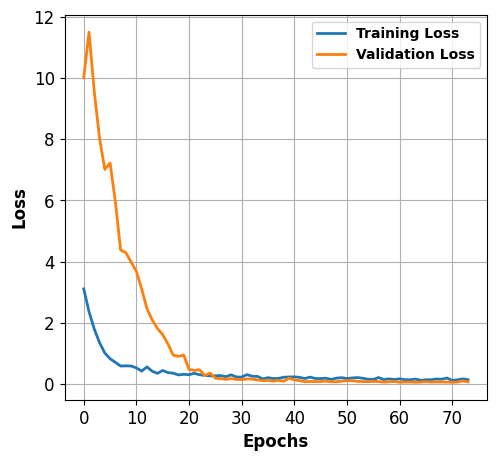

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(tabnet_model.history['loss'], label='Training Loss',linewidth=2)
plt.plot(tabnet_model.history['valid_logloss'], label='Validation Loss',linewidth=2)
plt.xlabel('Epochs',fontsize=12, fontweight='bold')
plt.ylabel('Loss',fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Training and Validation Loss for Unoptimized TabNet',fontsize=12, fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.grid(True)


In [ ]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

# Initialize TabNet Classifier
tabnet_opt = TabNetClassifier(
    n_d=32,       # Dimension of the prediction layer (similar to hidden units)
    n_a=32,       # Dimension of the attention layer
    n_steps=6,    # Number of decision steps
    gamma=1.3,    # Relaxation factor to control reuse of features
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', # This will be overwritten if using pretrain model

)

# Train TabNet model
tabnet_opt.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy', 'logloss'],              # Track accuracy and loss
    max_epochs=100,
    patience=10,  # Early stopping
    batch_size=128,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

# Evaluate the model
y_pred = tabnet_opt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.37997 | train_accuracy: 0.05966 | train_logloss: 14.82397| valid_accuracy: 0.03182 | valid_logloss: 15.42674|  0:00:01s
epoch 1  | loss: 1.18716 | train_accuracy: 0.10625 | train_logloss: 13.70683| valid_accuracy: 0.10455 | valid_logloss: 13.81201|  0:00:02s
epoch 2  | loss: 0.85241 | train_accuracy: 0.10909 | train_logloss: 12.41442| valid_accuracy: 0.08182 | valid_logloss: 13.07567|  0:00:02s
epoch 3  | loss: 0.62771 | train_accuracy: 0.08295 | train_logloss: 11.94667| valid_accuracy: 0.05455 | valid_logloss: 12.56408|  0:00:03s
epoch 4  | loss: 0.49148 | train_accuracy: 0.16705 | train_logloss: 10.4219 | valid_accuracy: 0.10455 | valid_logloss: 11.30969|  0:00:04s
epoch 5  | loss: 0.42272 | train_accuracy: 0.13011 | train_logloss: 11.14855| valid_accuracy: 0.08636 | valid_logloss: 11.88655|  0:00:04s
epoch 6  | loss: 0.35205 | train_accuracy: 0.22216 | train_logloss: 8.58934 | valid_accuracy: 0.24091 | valid_logloss: 8.51911 |  0:00:05s
epoch 7  | loss: 0.34847 | 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# Evaluate the model
y_val_pred = tabnet_opt.predict(X_val)
accuracy = accuracy_score(y_test, y_val_pred)
print(f"Test Accuracy: {accuracy}")

y_test_pred = tabnet_opt.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy}")

precision_val = precision_score(y_val, y_val_pred, average='weighted')
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')

# Test set metrics
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# Print results
print(f"\n--- {model_name} Metrics ---")
print(f"Validation Precision (weighted): {precision_val:.4f}")
print(f"Validation Recall (weighted): {recall_val:.4f}")
print(f"Validation F1-Score (weighted): {f1_val:.4f}")

print(f"Test Precision (weighted): {precision_test:.4f}")
print(f"Test Recall (weighted): {recall_test:.4f}")
print(f"Test F1-Score (weighted): {f1_test:.4f}")

Test Accuracy: 0.045454545454545456
Test Accuracy: 0.9954545454545455

--- RF Metrics ---
Validation Precision (weighted): 0.9797
Validation Recall (weighted): 0.9773
Validation F1-Score (weighted): 0.9775
Test Precision (weighted): 0.9959
Test Recall (weighted): 0.9955
Test F1-Score (weighted): 0.9954


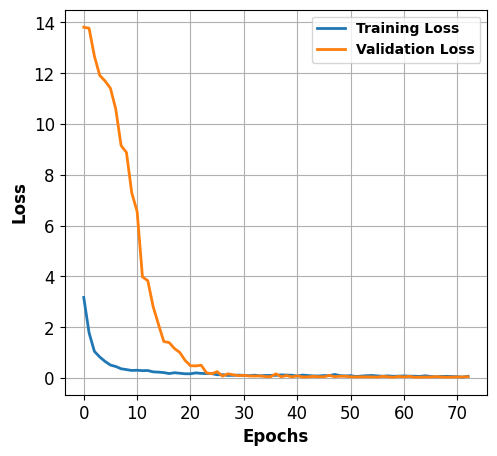

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(tabnet_opt.history['loss'], label='Training Loss',linewidth=2)
plt.plot(tabnet_opt.history['valid_logloss'], label='Validation Loss',linewidth=2)
plt.xlabel('Epochs',fontsize=12, fontweight='bold')
plt.ylabel('Loss',fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Training and Validation Loss for Optimized TabNet',fontsize=12, fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.grid(True)


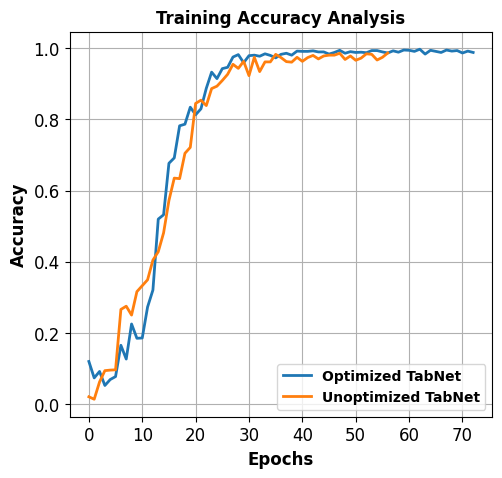

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(tabnet_opt.history['train_accuracy'], label='Optimized TabNet',linewidth=2)
plt.plot(tabnet_model.history['train_accuracy'], label='Unoptimized TabNet',linewidth=2)
plt.xlabel('Epochs',fontsize=12, fontweight='bold')
plt.ylabel('Accuracy',fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Training Accuracy Analysis',fontsize=12, fontweight='bold')
plt.legend(prop={'weight': 'bold'})
plt.grid(True)


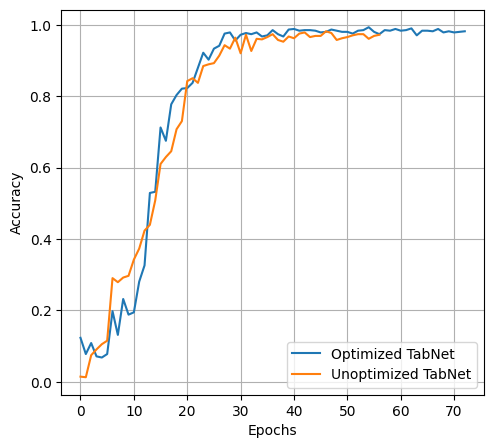

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(tabnet_opt.history['valid_accuracy'], label='Optimized TabNet')
plt.plot(tabnet_model.history['valid_accuracy'], label='Unoptimized TabNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)


In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert y_val to one-hot encoding (for ROC-AUC calculation)
y_val_onehot = to_categorical(y_val)

# Get probability predictions from TabNet
y_pred_probs = tabnet_opt.predict_proba(X_val)  # Ensure this returns probabilities

# Convert probabilities to class labels (highest probability class)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ROC AUC for Multi-Class (One-vs-Rest)
roc_auc = roc_auc_score(y_val_onehot, y_pred_probs, multi_class='ovr')
print("ROC AUC (OvR):", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Specificity Calculation (Confusion Matrix Approach)
specificities = []

for i in range(conf_matrix.shape[0]):  # Loop through each class
    tn = np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1).sum()  # True Negatives
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    specificities.append(specificity)

# Calculate Average Specificity
average_specificity = np.mean(specificities)
print("Average Specificity:", average_specificity)


ROC AUC (OvR): 0.9998689229488039
Average Specificity: 0.9989227798907865


In [ ]:
import time
import numpy as np

# Define models and datasets
models = {
    "TabNet": tabnet_model,
    "SVM": svm_model,
    "GBR": gbr_model,
    "RF": rf_model
}

datasets = {
    "Validation Set": X_val,
    "Test Set": X_test
}

# Measure inference time
for model_name, model in models.items():
    print(f"\n--- Measuring Inference Time for {model_name} ---")

    for dataset_name, X_data in datasets.items():

        # Ensure TabNet uses the correct prediction method
        if model_name == "TabNet":
            start_time = time.time()
            _ = model.predict_proba(X_data)  # Use predict() if predict_proba() is not available
        else:
            start_time = time.time()
            _ = model.predict(X_data)

        end_time = time.time()
        inference_time = end_time - start_time
        print(f"{dataset_name} Inference Time: {inference_time:.6f} seconds")



--- Measuring Inference Time for TabNet ---
Validation Set Inference Time: 0.016420 seconds
Test Set Inference Time: 0.010934 seconds

--- Measuring Inference Time for SVM ---
Validation Set Inference Time: 0.012329 seconds
Test Set Inference Time: 0.011677 seconds

--- Measuring Inference Time for GBR ---
Validation Set Inference Time: 0.009128 seconds
Test Set Inference Time: 0.007427 seconds

--- Measuring Inference Time for RF ---
Validation Set Inference Time: 0.008138 seconds
Test Set Inference Time: 0.006869 seconds


In [ ]:
import shap
import numpy as np
import pandas as pd

# Custom Wrapper to Make TabNet Callable for SHAP
class TabNetModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict_proba(X)

# Wrap the trained TabNet model
wrapped_model = TabNetModelWrapper(tabnet_opt)

# Ensure X_train and X_val are in DataFrame format for SHAP
X_traindf = pd.DataFrame(X_train)
X_valdf = pd.DataFrame(X_val)

# Initialize SHAP Explainer with KernelExplainer (Model Agnostic)
explainer = shap.KernelExplainer(wrapped_model.predict, shap.sample(X_traindf, 100))  # Sampling for efficiency

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valdf)



  0%|          | 0/264 [00:00<?, ?it/s]

In [ ]:
print(np.array(shap_values).shape)  # Shape of SHAP values
print(X_valdf.shape)  # Shape of validation data

(264, 7, 22)
(264, 7)


In [ ]:
feature_names = ['N', 'P', 'K', 'T', 'H', 'pH', 'R']
X_traindf.columns = feature_names
X_valdf.columns = feature_names

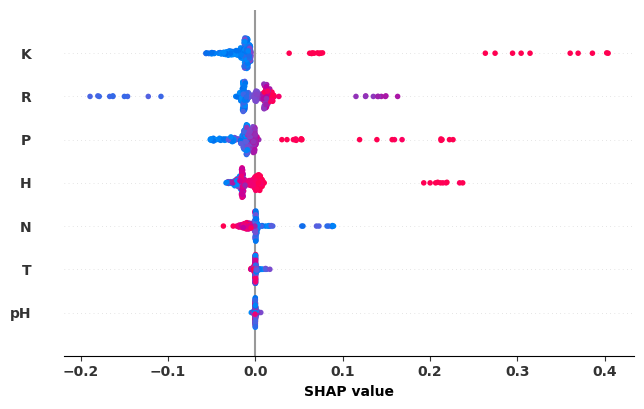

In [ ]:
plt.figure()
shap.summary_plot(shap_values[:, :, 0], X_valdf,show=False)
plt.xlabel("SHAP value", fontsize=10, fontweight='bold')
plt.xticks( fontsize=10, fontweight='bold')
plt.yticks( fontsize=10, fontweight='bold')
fig = plt.gcf()  # Get current figure
for ax in fig.axes:
   if ax.get_ylabel() == "Feature value":  # Identify the color bar by its label
     fig.delaxes(ax)  # Remove the color bar axis
plt.show()


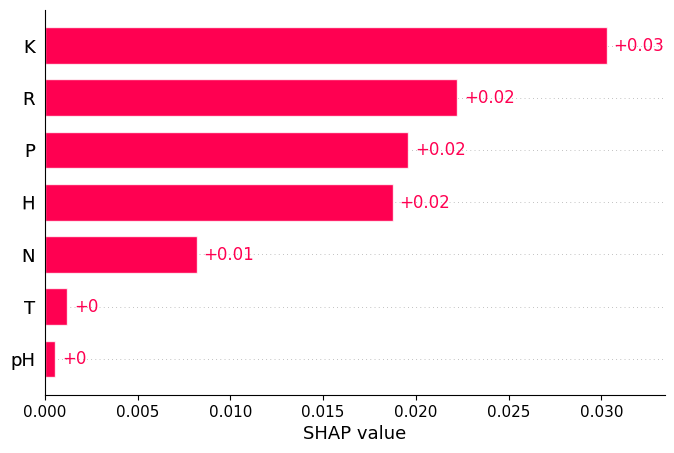

In [ ]:
# Select the SHAP values for the desired class (e.g., class 0)
class_index = 0  # Change this to the class index you are interested in
shap_values_for_class = shap_values[:, :, class_index]  # Shape: (n_samples, n_features)

# Average SHAP values across all samples for the selected class
mean_shap_values_class = np.mean(np.abs(shap_values_for_class), axis=0)  # Shape: (n_features,)

# Convert to SHAP Explanation object
explainer = shap.Explanation(values=mean_shap_values_class,
                             base_values=None,
                             data=None,
                             feature_names=feature_names)

# Plot the bar chart
shap.plots.bar(explainer)

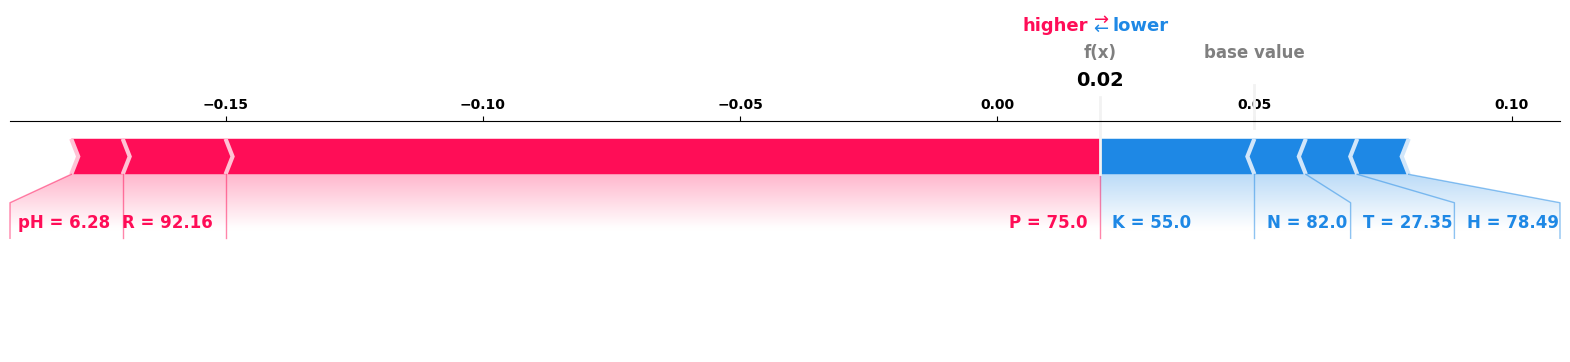

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
shap.initjs()

# Example feature names
feature_names = ['N', 'P', 'K', 'T', 'H','pH', 'R']

# Select the class and sample index for visualization
class_index = 0  # Target class
sample_index = 1  # Sample to visualize

# Extract SHAP values for the selected class and sample
shap_values_for_class = shap_values[sample_index, class_index, :]  # SHAP values for class and sample

# Extract the base value (expected value) for the selected class
expected_value = np.mean(wrapped_model.predict(X_train), axis=0)[class_index]

# Extract the feature vector for the selected sample
data_for_sample = X_valdf.iloc[sample_index, :]

# Ensure the feature vector matches SHAP value dimensions
if shap_values_for_class.shape != data_for_sample.shape:
    data_for_sample = np.resize(data_for_sample, shap_values_for_class.shape)

# Create Explanation object with feature names
explainer = shap.Explanation(
    values=shap_values_for_class,
    base_values=expected_value,
    data=data_for_sample,
    feature_names=feature_names  # Include feature names here
)
# Generate force plot
shap.plots.force(np.round(explainer.base_values,2), np.round(explainer.values,2), np.round(explainer.data,2), feature_names=[i for i in feature_names],    matplotlib=True,show=False)
# Customize feature labels to bold
for text in plt.gca().texts:
        text.set_fontweight('bold')  # Make all text elements bold


# Customize tick labels and axis properties
plt.xticks(fontsize=10, fontweight='bold')  # X-ticks in bold
plt.yticks(fontsize=10, fontweight='bold')  # Y-ticks in bold


# Show the customized plot
plt.show()
